## Projekt "Kaufen oder Warten"
Die Situation kennen alle, die ab und zu Flugtickets kaufen: Sollte man besser warten, weil der Preis vielleicht noch fällt, oder sollte man kaufen? Insbesondere bei der Fluggesellschaft, um die es in diesem Projekt geht, sind scheinbar erratische Preisveränderungen bekannt. Die übliche Regel "je früher, desto besser" ist hier oft nicht die beste Empfehlung.

## Datenbeschreibung
Der Datensatz train_set.csv enthält Preisanfragen zu bestimmten Zeitpunkten für Flüge. Es werden nur zwei verschiedene Strecken in beiden Richtungen betrachtet: zwischen London Stansted und Berlin Schönefeld sowie zwischen London Stansted und Frankfurt.

Die folgenden Merkmale sind enthalten:

Request_Date: Datum und Uhrzeit der Preisanfrage
Flight_Date: Datum des Flugs
Departure_hour: Gerundete Abflugszeit
flight_unique_id: Eindeutige ID für den Flug
route_abb: Abkürzung der Flugroute
Price_In_Eur: Flugpreis
min_future_price_in_Eur: Minimaler Flugpreis für die flight_unique_id über alle zukünftigen Request_Dates
buy: 1 = kaufen, 0 = warten (vorherzusagende Klasse)
Die buy-Klasse wird wie folgt berechnet: if Price_In_Eur - min_future_price_in_Eur <= 0 then 1 else 0

## Aufgabe
Sie sollen ein Modell für eine Kaufempfehlung aus den Daten lernen. Interpretieren Sie ein Zeile in dem Datensatz als eine Preisabfrage, die Sie als Kunde durchführen. Das zu lernende Modell soll Ihnen dann empfehlen, zu dem Preis zu kaufen oder besser zu warten.

Für den ersten Teil der Arbeit überlegen Sie sich, wie Sie solch ein Modell in der Praxis gestalten und anwenden würden. Versetzen Sie sich dazu in die Lage eines Kunden und/oder in die Lage eines Unternehmens. Was könnte bei letzterem das Geschäftsmodell sein?

Welchen Einfluss haben diese Überlegungen auf das Konzept des zu lernenden Modells?

Halten Sie sich beim Vorgehen bitte an die allgemeinen Schritte, die ich oben für alle Projekte beschrieben habe.

## Modellgüte
Benutzen Sie zunächst einfache Vorhersagegenauigkeit zur Beurteilung der Modellgüte (Accuracy). Messen Sie also die Anzahl der richtigen Entscheidungen (Kaufen oder Warten) durch die Anzahl aller Entscheidungen.

Überlegen Sie dann, wie man aus Sicht eines Kunden bzw. Ihres Geschäftsmodells die Güte der Kaufempfehlungen messen sollte. Hier spielen sicher monetäre Überlegungen und Kundenzufriedenheit eine größere Rolle als nur möglichst genaue Empfehlungen. Denken Sie hierbei auch daran, dass man sich als Kunde nicht dem Stress aussetzen möchte, ständig Preise abzufragen.

Sie werden Ihre Ideen bei der Zwischenpräsentation vorstellen und diskutieren. Sie haben dann die Gelegenheit, für den zweiten Teil der Arbeit (Bauen der Modelle) Ihre Überlegungen basierend auf den Diskussionen anzupassen und auch Ideen von anderen Gruppen aufzunehmen.

## Wettbewerb
Es gibt einen Testdatensatz (s.u.), der dasselbe Datenformat wie der Trainingsdatensatz aufweist - nur die Spalten min_future_price_in_Eur und buy fehlen, da diese in der Anwendungssituation nicht bekannt wären. Für die Abgabe der Arbeit sollen Sie Ihre Modelle auf den Testdatensatz anwenden und das Ergebnis mit abgeben (Beschreibung siehe beim Abgabetermin weiter oben in Moodle). Wir werden die besten Modelle als Sieger küren, wenn alle Gruppen abgegeben haben.

Dazu werden wir zwei verschiedene Gütemaße betrachten: die einfache Genauigkeit (Accuracy) und das monetäre Gütemaß, auf das wir uns noch einigen werden.

In [1]:
import time
import pandas as pd
pd.set_option("display.max_columns", None)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import seaborn as sns
sns.set_theme(style="whitegrid")
from datetime import datetime
from dateutil import tz
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, mutual_info_classif,RFECV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedGroupKFold,StratifiedKFold,cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report,accuracy_score, f1_score,roc_curve, auc

In [2]:
# Trainingsdaten in einer Dataframme einlesen
flug_df = pd.read_csv("https://raw.githubusercontent.com/hahaha996/Data_Mining_Projekt/main/datasets/Data_Mining_Datasets/train_set.csv")
# Die fünf ersten Objekte ausgeben
flug_df.head()

,index,Request_Date,Flight_Date,Departure_hour,flight_unique_id,route_abb,Price_In_Eur,min_future_price_in_Eur,buy
0,1,2019-06-03T11:00:00Z,2019-06-05,19,2019-06-05 FR 146,SXF-STN,208.07,259.07,1
1,2,2019-06-03T23:00:00Z,2019-06-05,19,2019-06-05 FR 146,SXF-STN,259.07,259.07,1
2,3,2019-06-04T11:00:00Z,2019-06-05,19,2019-06-05 FR 146,SXF-STN,259.07,259.07,1
3,4,2019-06-04T23:00:00Z,2019-06-05,19,2019-06-05 FR 146,SXF-STN,259.07,259.07,1
4,5,2019-06-03T11:00:00Z,2019-06-05,21,2019-06-05 FR 147,STN-SXF,143.86,251.72,1


In [3]:
# Trestdaten in einer Dataframme einlesen
flug_df_test = pd.read_csv("https://raw.githubusercontent.com/hahaha996/Data_Mining_Projekt/main/datasets/Data_Mining_Datasets/test_set.csv")
# Die fünf letzten Objekte ausgeben
print(flug_df_test.tail())

# Prüfen, ob Merkmale in Training vorhanden sind, die in Testdaten fehlen
print(f"\nFolgende Merkmale fehlen in Testdaten: {set(flug_df) - set(flug_df_test)}")


      index          Request_Date Flight_Date  Departure_hour  \
5578   5579  2019-07-30T23:00:00Z  2019-08-02              22   
5579   5580  2019-07-31T11:00:00Z  2019-08-02              22   
5580   5581  2019-07-31T23:00:00Z  2019-08-02              22   
5581   5582  2019-08-01T11:00:00Z  2019-08-02              22   
5582   5583  2019-08-01T23:00:00Z  2019-08-02              22   

        flight_unique_id route_abb  Price_In_Eur  
5578  2019-08-02 FR 8545   SXF-STN         42.83  
5579  2019-08-02 FR 8545   SXF-STN         50.99  
5580  2019-08-02 FR 8545   SXF-STN         50.99  
5581  2019-08-02 FR 8545   SXF-STN         50.99  
5582  2019-08-02 FR 8545   SXF-STN         50.99  

Folgende Merkmale fehlen in Testdaten: {'buy', 'min_future_price_in_Eur'}


## Deskriptive Datenanalyse

In [4]:
# Funktion zur Ausgabe von Informationen über den DataFrame einschließlich Indexdatentyps 
#Spalten und Nicht-Null-Werte

def check_data(data, data_type):
    
    print(f"---------------------------------------\nGrundaten über {data_type} Dataset\n---------------------------------------")
    print(f"Anzahl von Datenpunkten: {len(data)}")
    print(f"Anzahl von Merkmalen: {len(data.columns)}\n")
    print(f"Datentypen:\n-----------\n{data.dtypes} \n")
    print(f"Fehlende Werte:\n---------------\n{data.isnull().sum()} \n")
    print(f"Statistiken numerische Werten:\n-------------------------------\n{data.describe().transpose()}")
    print(f"\nStatistiken kategorische Werten:\n-------------------------------\n{data.describe(include='O').transpose()}")
    print(f"\nAnzahl von Duplicates in {data_type}: {len(data.loc[data.duplicated()])}\n")
   

    
check_data(flug_df,'Trainingsdaten')

check_data(flug_df_test,'Testdaten')

---------------------------------------
Grundaten über Trainingsdaten Dataset
---------------------------------------
Anzahl von Datenpunkten: 83624
Anzahl von Merkmalen: 9

Datentypen:
-----------
index                        int64
Request_Date                object
Flight_Date                 object
Departure_hour               int64
flight_unique_id            object
route_abb                   object
Price_In_Eur               float64
min_future_price_in_Eur    float64
buy                          int64
dtype: object 

Fehlende Werte:
---------------
index                      0
Request_Date               0
Flight_Date                0
Departure_hour             0
flight_unique_id           0
route_abb                  0
Price_In_Eur               0
min_future_price_in_Eur    0
buy                        0
dtype: int64 

Statistiken numerische Werten:
-------------------------------
                           count          mean           std   min       25%  \
index               

Die Trainingsdaten bestehen aus 8 Features(Spalten)  und 83624 Exemplare (Zeilen). Davon sind 4 Spalten vom Datentyp "object", was mit String gleichzusetzen ist: Request_date, Flight_date, flight_unique_id und route_abb. Die Spalten Departure_hour und buy enthalten ganze Zahlen vom Typ int64 und die Spalten Price_In_Eur und min_future_price_in_Eur gleitkomma Zahlen vom Typ float64.
Die Statistiken zeigen unterschiedliche statischen Werte von Merkmalen. Je nachdem ob der Spalte numerische Werte oder Zeichenfolge enthält wechseln die Parameter ab. Für numerische Werte werden Anzahl(count), durschnittliche Mittelwert(mean), Standardabweichung(std), Minimum(min), Maximum(max) und Percentiles(25%,50% und 75%) berechnet. Für Zeichenfolge werden hingegen Anzahl(count), Anzahl eindeutige Werte(unique), häufigste Wert(top) und wie oft dieser Wert in den Daten vorkommt(freq) berechnet.


##### Nachfolgend werden die Wertebereiche für die numerische Spalten mit Boxplots veranschaulicht 

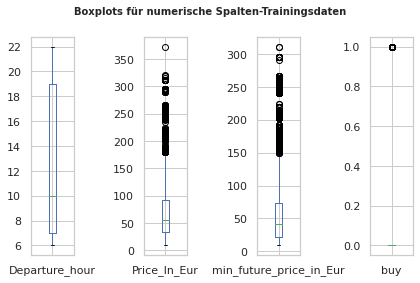

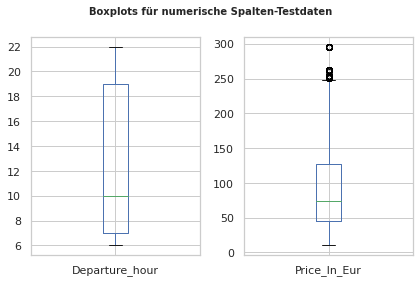

In [5]:

font = font_manager.FontProperties(family='DejaVu Sans',
                                   weight='bold',
                                   style='normal', size=10)
def Num_Spalten_visuals(dataframe, datentyp):
    
    cols = dataframe.columns
    new_col = []
    for col in cols:
        if (dataframe[col].dtypes == 'int64' or dataframe[col].dtypes == 'float64') and (col != 'index'):
            new_col.append(col)
    dataframe[new_col].plot(subplots=True,kind='box')
    plt.suptitle('Boxplots für numerische Spalten'+ datentyp,fontproperties=font)
    plt.tight_layout()
    plt.show()    

Num_Spalten_visuals(flug_df,'-Trainingsdaten')
Num_Spalten_visuals(flug_df_test,'-Testdaten')



Aus dem obigen Diagramm können wir ableiten, dass dieSpalten "Price_in_Eur" und "min_future_price_in_Eur" Ausreißer enthalten. Die Ausreißer liegen in Trainingsdaten liegen nach dem Wert "150" für min_future_price_in_Eur und nach ca "180" für Price_In_Eur".
Die Abflüge finden von 6 Uhr bis 22 Uhr statt. Für alle Abfragen gilt: Der günstigste Flug kostet 8,99 € und der teuerste 372,96

In [6]:
# Find the 75th and 25th percentiles für Price_In_Eur
price_seventy_fifth = flug_df["Price_In_Eur"].quantile(0.75)
price_twenty_fifth = flug_df["Price_In_Eur"].quantile(0.25)

# Calculate iqr
prices_iqr = price_seventy_fifth - price_twenty_fifth

# Calculate the thresholds
upper = price_seventy_fifth + (1.5 * prices_iqr)
lower = price_twenty_fifth - (1.5 * prices_iqr)

# Subset the data without outliers
flug_df_ohne_Outliers_Price = flug_df[(flug_df["Price_In_Eur"] > lower) & (flug_df["Price_In_Eur"] < upper)]

print(flug_df_ohne_Outliers_Price["Price_In_Eur"].describe())

count    78744.000000
mean        62.318011
std         39.223014
min          8.990000
25%         30.330000
50%         52.510000
75%         85.190000
max        180.210000
Name: Price_In_Eur, dtype: float64


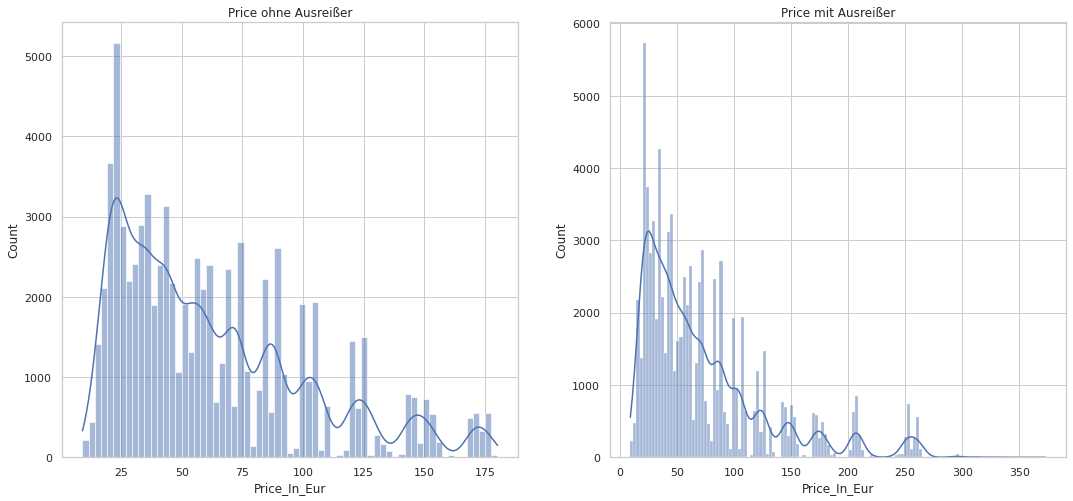

In [7]:
# Datenverteilung "Price_In_Eur" ohne Ausreißer
f,ax=plt.subplots(1,2,figsize=(18,8))
sns.histplot(data=flug_df_ohne_Outliers_Price,x='Price_In_Eur',kde='True',ax=ax[0])
ax[0].set_title('Price ohne Ausreißer')

# Datenverteilung "Price_In_Eur" mit Ausreißer
sns.histplot(data=flug_df,x='Price_In_Eur',kde='True',ax=ax[1])
ax[1].set_title('Price mit Ausreißer')
plt.show()


## Datentypkonvertierung

Wenn wir die Daten, die in den Spalten vorkommen mit ihren Datentypen vergleichen,stellt man fest, dass einige Feautures nicht der richtige Datentyp haben.Zum Beispiel 'Buy' hier ist die vorherzusagende Klasse, deswegen sollte der Feature vom Datentyp 'Category'sein. 
Die Feautures 'Request_Date'und 'Flight_Date' sollten vom Datentyp 'datetime' sein. Der Feature 'Request_Date' ist im UTC-Format gespeichert, Deswegen muss er erstmal in Localen Format umkonvertiert werden.
Der Datentyp des Features 'buy' wird später auch für das Training in den Datentyp 'category' konvertiert, da es sich hierbei um die vorherzusagende Klasse handelt.

In [8]:
def local_time(row):
    if row['route_abb'].split('-')[0] == 'SXF' or row['route_abb'].split('-')[0] == 'FRA':
        # Zeitzone
        zone = "Europe/Berlin"
    else:
        # Zeitzone
        zone = "Europe/London"
    
    # Konvertierung in ein datetime-Objekt
    dtUTC = datetime.strptime(row['Request_Date'], '%Y-%m-%dT%H:%M:%SZ')
    dtZone = dtUTC.replace(tzinfo=tz.gettz('UTC')).astimezone(tz.gettz(zone))
    
    # Formatierung des DateTime-Strings ohne Zeitzonen-Offset-Information
    dtString = dtZone.strftime('%Y-%m-%d %H:%M:%S')
    
    # Rückgabe des konvertierten Werts
    return pd.to_datetime(dtString)

# Konvertierung Trainingsdaten
flug_df['Request_Date'] = flug_df.apply( local_time, axis=1)
#flug_df['buy']= flug_df['buy'].astype('category')
flug_df['Flight_Date']= pd.to_datetime(flug_df['Flight_Date']) 

# Konvertierung Trainingsdaten
flug_df_test['Request_Date'] = flug_df_test.apply( local_time, axis=1) 
flug_df_test['Flight_Date']= pd.to_datetime(flug_df['Flight_Date'])
   
print(f"Datentyp von Features nach Konvertierung: Trainingsdaten\n\n{flug_df.dtypes}")
print(f"\nDatentyp von Features nach Konvertierung: Testdaten\n\n{flug_df_test.dtypes}")

Datentyp von Features nach Konvertierung: Trainingsdaten

index                               int64
Request_Date               datetime64[ns]
Flight_Date                datetime64[ns]
Departure_hour                      int64
flight_unique_id                   object
route_abb                          object
Price_In_Eur                      float64
min_future_price_in_Eur           float64
buy                                 int64
dtype: object

Datentyp von Features nach Konvertierung: Testdaten

index                        int64
Request_Date        datetime64[ns]
Flight_Date         datetime64[ns]
Departure_hour               int64
flight_unique_id            object
route_abb                   object
Price_In_Eur               float64
dtype: object


## Korrelationen

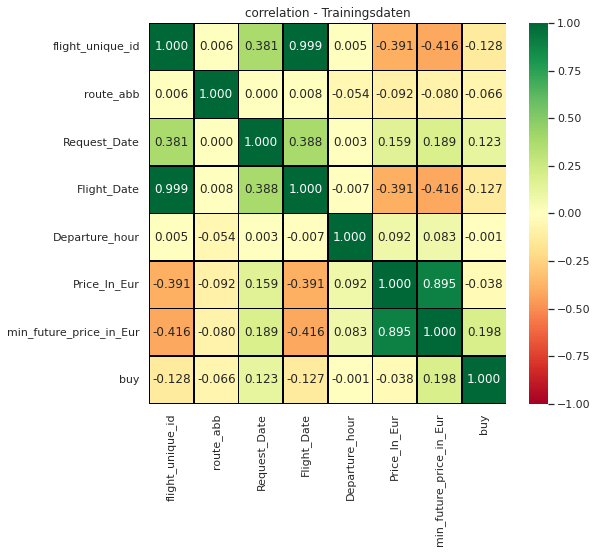

In [9]:
# Merkmale in numerische und nominale trennen
colcat = ['flight_unique_id', 'route_abb','Request_Date','Flight_Date']
colnum = ['Departure_hour','Price_In_Eur','min_future_price_in_Eur','buy']

#Erstellung numerischer Darstellungen von kategorialen Variablen in Trainingsdaten
df = flug_df[colcat].apply(lambda x : pd.factorize(x)[0])
df_concat = pd.concat([df,flug_df[colnum]], axis=1) 

# Berechnung der Korrelationsmatrix
corrmat=df_concat.corr(method='pearson')

# Visualisierung der Koorelationsmatrix
plt.figure(figsize=(8,7))
sns.heatmap(corrmat, annot=True,
            fmt='.3f',
            linecolor='black', linewidths=.5,
            cmap='RdYlGn', vmin=-1, vmax=+1)
plt.title('correlation - Trainingsdaten')
plt.show()

Die Korrelation zeigt, dass die beiden Merkmale 'Buy' und 'min_future_price_in_Eur' korreliert sind und ein proportionalen Verhältnis aufweisen. Wenn der Wert von 'Buy' steigt, steigt auch der Wert von 'min_future_price_in_Eur'.

## Explorative Datenanalyse

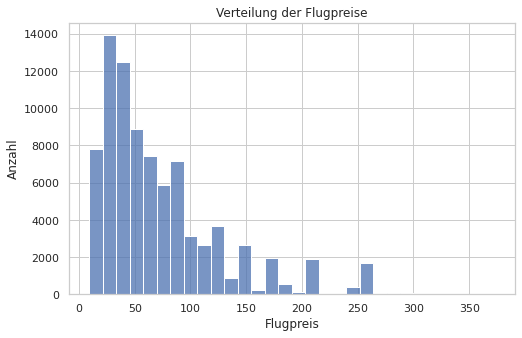

In [10]:
plt.figure(figsize=(8, 5))
sns.histplot(flug_df['Price_In_Eur'], bins=30)
plt.xlabel('Flugpreis')
plt.ylabel('Anzahl')
plt.title('Verteilung der Flugpreise')
plt.show()

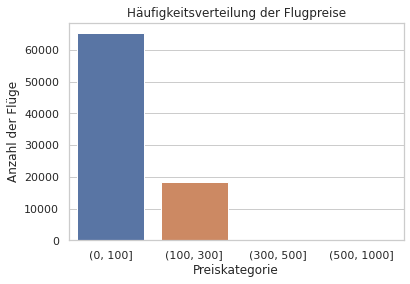

In [11]:
bins = [0, 100, 300, 500, 1000]  # Beispielkategorien für die Preise
flug_df['Price_Category'] = pd.cut(flug_df['Price_In_Eur'], bins=bins)
sns.countplot(data=flug_df, x='Price_Category')
plt.title('Häufigkeitsverteilung der Flugpreise')
plt.xlabel('Preiskategorie')
plt.ylabel('Anzahl der Flüge')
plt.show()

Bei unseren Daten geht es angeblich, um eine güngstige Fluggesellschaft. Die Meisten Flügen kosten relativ wenig.

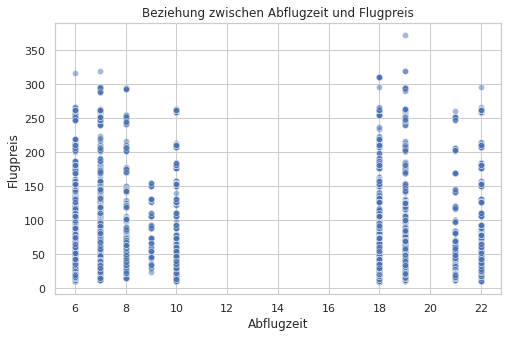

In [12]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x='Departure_hour', y='Price_In_Eur', data=flug_df, alpha=0.5)
plt.xlabel('Abflugzeit')
plt.ylabel('Flugpreis')
plt.title('Beziehung zwischen Abflugzeit und Flugpreis')
plt.show()

In unserem Datensatz sind nur Flüge für Vormittag, Abend und Nacht mit einer ziemlich unregelmäßige Verteilung aufgelistet.
Es scheint keine klare lineare Beziehung zwischen der Abflugzeit und dem Flugpreis zu geben. Das bedeutet, dass der Flugpreis nicht einfach mit der Abflugzeit steigt oder fällt.Es gibt jedoch einige sichtbare Streifenmuster, die möglicherweise darauf hindeuten, dass es bestimmte Zeitfenster gibt, in denen die Flugpreise ähnlich sind. 

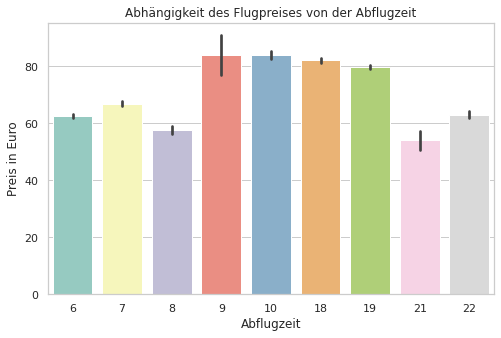

In [13]:
# Abhängigkeit des Flugpreises von der Abflugzeit
plt.figure(figsize=(8,5))
sns.barplot(data=flug_df, x='Departure_hour',y='Price_In_Eur', palette='Set3')
plt.title('Abhängigkeit des Flugpreises von der Abflugzeit')
plt.xlabel('Abflugzeit')
plt.ylabel('Preis in Euro')
plt.show()

Es scheint, dass es bestimmte Abflugzeiten gibt, zu denen die Flugpreise tendenziell höher oder niedriger sind.
Zum Beispiel scheinen die Flugpreise in den frühen Morgenstunden oder in den späten Abendstunden tendenziell niedriger zu sein, während die Preise während der Hauptreisezeiten höher sind (zwischen 9 und 19 Uhr).

<Figure size 576x360 with 0 Axes>

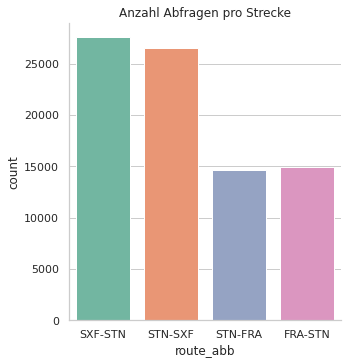

In [14]:
# Welche Strecken werden am meisten abgefragt?
plt.figure(figsize=(8,5))
sns.catplot(x='route_abb', data=flug_df, kind='count', palette='Set2')
plt.title('Anzahl Abfragen pro Strecke')
plt.show()

Die Strecken Berlin-Stansted und Stansted-Berlin scheinen mehr abgefragt zu sein als die andere. Deswegen schauen wir uns die Strecke genauer an.

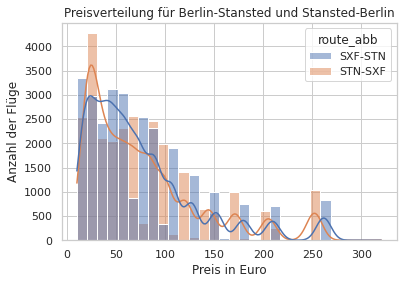

In [15]:
sns.histplot(data=flug_df[flug_df['route_abb'].isin(['SXF-STN', 'STN-SXF'])], x='Price_In_Eur', bins=30, hue='route_abb',
             kde=True)
plt.title('Preisverteilung für Berlin-Stansted und Stansted-Berlin')
plt.xlabel('Preis in Euro')
plt.ylabel('Anzahl der Flüge')
plt.show()

Die Verteilung zeigt, dass es relativ wenige Flüge mit sehr hohen Preisen gibt, was darauf hindeuten könnte, dass teure Flüge eher die Ausnahme als die Regel sind.

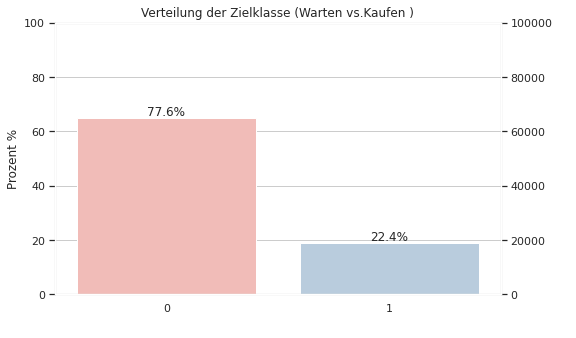

In [16]:
def default():
    ncount = len(flug_df)

    ax2=ax.twinx()

    ax2.yaxis.tick_left()
    ax.yaxis.tick_right()

    ax.yaxis.set_label_position('right')
    ax2.yaxis.set_label_position('left')

    ax2.set_ylabel('Prozent %')
    plt.title("Verteilung der Zielklasse (Warten vs.Kaufen )")

    for i in ax.patches:
        x=i.get_bbox().get_points()[:,0]
        y=i.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
                ha='center', va='bottom')

    ax2.set_ylim(0,100)
    ax2.grid(None)

ax = sns.countplot(x=flug_df.buy, palette="Pastel1")
sns.set(font_scale=1.)
ax.set_ylim(top=100000)
ax.set_xlabel(' ')
ax.set_ylabel(' ')
fig = plt.gcf()
fig.set_size_inches(8,5)
ax.set_ylim(top=100000)

default()

plt.show()


Die prozentuale Verteilung zeigt, dass der Anteil der Flüge, bei denen die Entscheidung "Kaufen" getroffen wird, relativ gering ist, verglichen mit denen, bei denen die Entscheidung "Warten" getroffen wird. Wir haben  64906 warten und nur 18718 kaufen. Das Diagramm zeigt, dass die Zielvariable "buy" unbalanciert ist, da es einen deutlichen Ungleichgewicht zwischen den beiden Zielklassen gibt. Solche Ungleichgewichte können bei der Modellierung berücksichtigt (Stratifizierung ) werden, um die Leistung des Modells zu verbessern und mögliche Verzerrungen zu reduzieren.

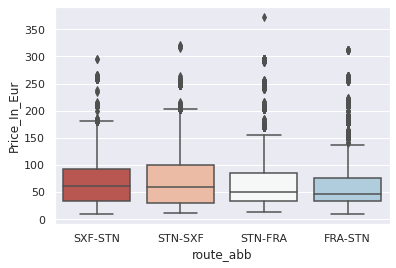

Der Mittelpreis liegt bei 74.79 wenn man der Preis von Berlin nach London abfragt
Der Mittelpreis liegt bei 77.38 wenn man der Preis von London nach Berlin  abfragt
Der Mittelpreis liegt bei 67.57 wenn man der Preis von London nach Frankfurt  abfragt
Der Mittelpreis liegt bei 61.45 wenn man der Preis von Frankfurt nach London abfragt


In [17]:
# wie teuer sind die Flüge auf die unterschiedlichen Strecken?
sns.boxplot(x = 'route_abb', y =flug_df['Price_In_Eur'], data = flug_df, palette = sns.color_palette('RdBu',5))
plt.show()
route_SXF_STN = flug_df.loc[flug_df['route_abb'] =='SXF-STN', 'Price_In_Eur']
route_STN_SXF= flug_df.loc[flug_df['route_abb'] =='STN-SXF', 'Price_In_Eur']
route_STN_FRA = flug_df.loc[flug_df['route_abb'] =='STN-FRA', 'Price_In_Eur']
route_FRA_STN = flug_df.loc[flug_df['route_abb'] =='FRA-STN', 'Price_In_Eur']
print("Der Mittelpreis liegt bei {}".format(round(route_SXF_STN.mean(), 2)), "wenn man der Preis von Berlin nach London abfragt")
print("Der Mittelpreis liegt bei {}".format(round(route_STN_SXF.mean(), 2)), "wenn man der Preis von London nach Berlin  abfragt")
print("Der Mittelpreis liegt bei {}".format(round(route_STN_FRA.mean(), 2)), "wenn man der Preis von London nach Frankfurt  abfragt")
print("Der Mittelpreis liegt bei {}".format(round(route_FRA_STN.mean(), 2)), "wenn man der Preis von Frankfurt nach London abfragt")

Das Boxplot-Diagramm, dass die Flugpreise je nach Strecke variieren und dass einige Strecken tendenziell niedrigere Preise haben (STN-FRA und FRA-STN) als andere. Die Streuung der Flugpreise für "STN-FRA" und "FRA-STN" ist größer, was darauf hindeutet, dass es bei diesen Strecken mehr Variation in den Preisen gibt.

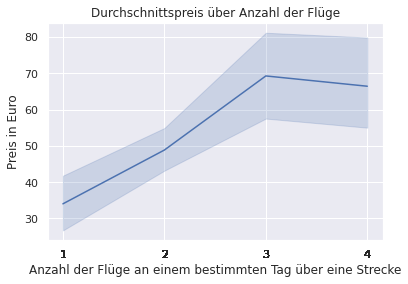

Die maximale Anzahl von Flüge an einem bestimmten Tag über eine Strecke ist 4.
Je mehr Flüge es gibt, desto höher sind die Preise.


In [18]:
# Anzahl Flüge für eine Strecke an einem bestimmten Tag

f = flug_df.groupby(['Flight_Date', 'route_abb']).nunique()[['flight_unique_id', 'Price_In_Eur']]
max_flights = max(f.reset_index()['flight_unique_id'])

sns.lineplot(data=f, x='flight_unique_id', y='Price_In_Eur')
plt.xticks(f['flight_unique_id'])
plt.xlabel('Anzahl der Flüge an einem bestimmten Tag über eine Strecke')
plt.ylabel('Preis in Euro')
plt.title(f'Durchschnittspreis über Anzahl der Flüge')
plt.show()
print(f'Die maximale Anzahl von Flüge an einem bestimmten Tag über eine Strecke ist {max_flights}.\n\
Je mehr Flüge es gibt, desto höher sind die Preise.')

In den meisten Fällen sinkt der Durchschnittspreis, ab 3 Flüge an einem bestimmten Tag über eine Strecke. Dies deutet darauf hin, dass die Fluggesellschaft möglicherweise Preissenkungen vornimmt, wenn mehr Flüge auf einer bestimmten Strecke geplant sind, um die Nachfrage zu erhöhen.

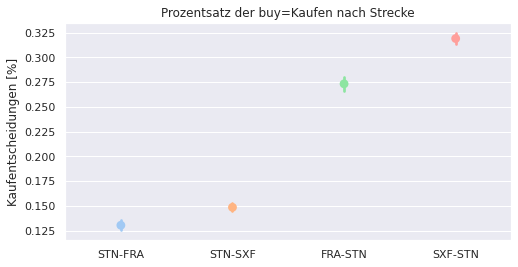

In [19]:
plt.figure(figsize=(8, 4))


source_destination_buy_percentage = flug_df.groupby('route_abb')['buy'].mean() * 100
sorted_source_destination = source_destination_buy_percentage.sort_values().index

sns.pointplot(data=flug_df, x='route_abb', y='buy', order=sorted_source_destination, join=False, palette='pastel')
plt.title('Prozentsatz der buy=Kaufen nach Strecke')
plt.ylabel('Kaufentscheidungen [%]')
plt.xlabel('') 
plt.show()

Das Punktdiagramm zeigt, wie der Prozentsatz der Kaufentscheidungen für verschiedene Strecken variiert. Es kann Hinweise darauf geben, welche Strecken beliebter sind und welche Strecken eher zu Kaufentscheidungen führen.Die meisten positiven Kaufentscheidungen werden für die Strecke Berlin-Standsted getroffen, gefolgt von der Strecke Frankfurt-Stansted.

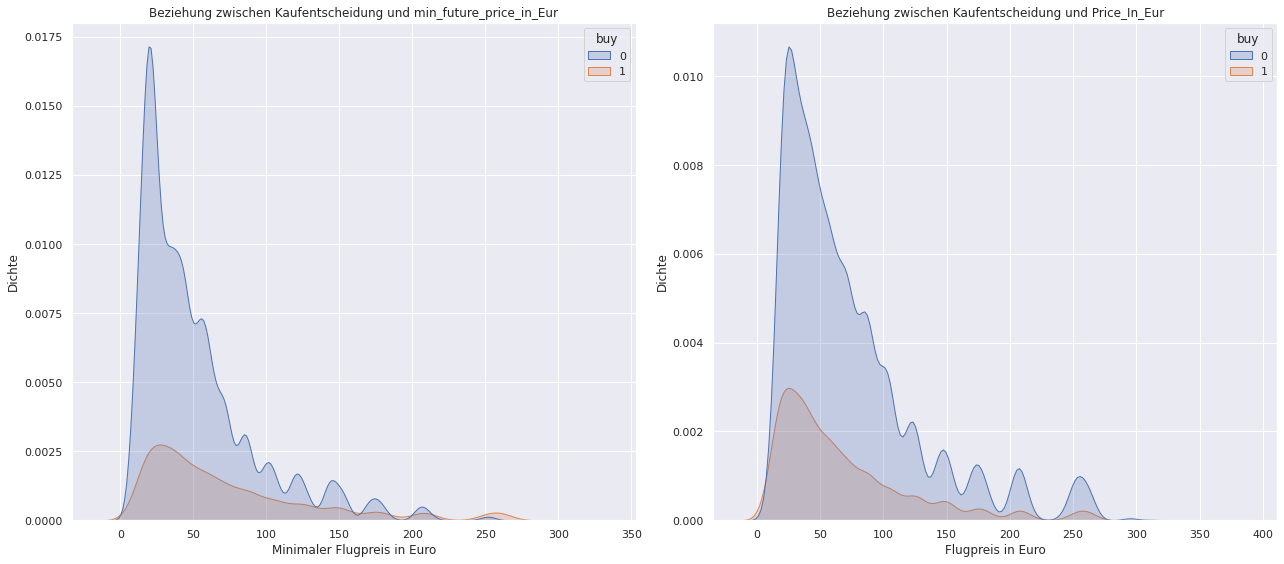

In [20]:
plt.figure(figsize=(18, 8))

# Diagramm für 'min_future_price_in_Eur'
plt.subplot(1, 2, 1)
sns.kdeplot(data=flug_df, x="min_future_price_in_Eur", hue="buy", fill=True)
plt.title('Beziehung zwischen Kaufentscheidung und min_future_price_in_Eur')
plt.ylabel('Dichte')
plt.xlabel('Minimaler Flugpreis in Euro')

# Diagramm für 'Price_In_Eur'
plt.subplot(1, 2, 2)
sns.kdeplot(data=flug_df, x="Price_In_Eur", hue="buy", fill=True)
plt.title('Beziehung zwischen Kaufentscheidung und Price_In_Eur')
plt.ylabel('Dichte')
plt.xlabel('Flugpreis in Euro')

plt.tight_layout()
plt.show()


Diese Diagramme zeigen die Verteilung der  'min_future_price_in_Eur' und 'Price_In_Eur' nach Kaufentscheidungen ('buy'). Es zeigt, ob die minimalen zukünftigen Flugpreise/ aktuelle Flugpreis einen Einfluss auf die Kaufentscheidung haben könnten.

Die geringe Überlappung zwischen den beiden Dichtekurven in beiden Diagrammen zeigt, dass es eine signifikante Unterscheidung zwischen den Kauf- und Wartedaten gibt. In Bezug auf den aktuellen Preis ('Price_In_Eur') und den minimalen zukünftigen Preis ('min_future_price_in_Eur') tendieren Käufer dazu, bei niedrigeren Preisen zu kaufen und bei höheren Preisen zu warten.

## Feature ingeneering

Basierend auf die vorhandenen Merkmalen können weitere abgeleitete Merkmale definiert werden:

- **days_diff_Req_Flight**: Zeitdauer bis zum Flug in Tagen (berechnet als Flight_Date - Request_Date)
- **Flight_DayofWeek**: Wochentag des Flugs (0 bis 6)
- **Flight_Month**: Monat des Flugs  (1 bis 12)
- **Flight_weekofyear**: Kalenderwoche des Flugs
- **Weekend**: Ein binäres Merkmal , das angibt, ob der Flug am Wochende ist.
- **Saison**: Ein Merkmal, das die Saison des Jahres (Frühling, Sommer, Herbst, Winter) basierend auf dem Flugdatum angibt.
- **Request_DayofWeek**: Wochentag  der Abfrage (0 bis 6)
- **Request_Month**: Monat  der Abfrage (1 bis 12)
- **Departure_time und Request_time**: als Umrechnung jeweils des Abflugszeit und Abfragezeit in Tageszeiten
- **Source und Destination**: als Zerlegung der Strecke in Start- und Endpunkt
- **Price_in_eur_max,-min, und -mean**: als maximaler, minimaler und mittlerer Preis für einen Flug auf eine bestimmte Strecke
- **Number_of_request**: als Anzahl von Abfrage je Flug



In [21]:
def generate_features(dataframe):
    #eine Reihe von Merkmalen unter Verwendung der Datumsspalten erstellen
    dataframe.loc[:,'Request_Dayofweek'] = dataframe['Request_Date'].dt.dayofweek
    dataframe.loc[:,'Request_month'] = dataframe['Request_Date'].dt.month
    dataframe.loc[:,'days_diff_Req_Flight'] = (pd.to_datetime(dataframe['Flight_Date'])- pd.to_datetime(dataframe['Request_Date'])).dt.days
    dataframe.loc[:,'Flight_Dayofweek'] = dataframe['Flight_Date'].dt.dayofweek
    dataframe.loc[:,'Flight_month'] = dataframe['Flight_Date'].dt.month
    dataframe.loc[:,'Flight_weekofyear'] = dataframe['Flight_Date'].dt.isocalendar().week
    dataframe.loc[:,'weekend']= (dataframe['Flight_Date'].dt.weekday >=5).astype(int)
    
    # Umrechnung der Departure_hour in Vormittag/Nachmittag/Abend usw.
    s = (dataframe["Departure_hour"] % 24 + 4) // 4 #give numbers from 1 to 6 #(return a series)
    # Werte ersetzen 1:latenight to 6: night
    s.replace({1: 'Late Night', 2: 'Early Morning', 3: 'Morning', 
                      4: 'Afternoon', 5: 'Evening', 6: 'Night'} ,inplace = True) 
    dataframe["departure_time"] = s
    
    # Umrechnung der Request_Time in Vormittag/Nachmittag/Abend usw.
    t = (dataframe['Request_Date'].dt.hour % 24 + 4) // 4 #give numbers from 1 to 6 #(return a series)
    # Werte ersetzen 1:latenight to 6: night
    t.replace({1: 'Late Night', 2: 'Early Morning', 3: 'Morning', 
                      4: 'Afternoon', 5: 'Evening', 6: 'Night'} ,inplace = True) 
    dataframe["Request_time"] = t
  

    #Die Merkmales source und destination aus dem Spalten route_abb erstellen
    
      
    dataframe['source'] =''
    dataframe['destination'] =''
    unique_routes = dataframe['route_abb'].unique()
    for route in unique_routes:
        if route == 'SXF-STN':
            dataframe.loc[dataframe['route_abb'] == route, 'source'] = 'Berlin'
            dataframe.loc[dataframe['route_abb'] == route, 'destination'] = 'London'
        elif route == 'STN-SXF':  # Weitere Ausprägungen hinzufügen
            dataframe.loc[dataframe['route_abb'] == route, 'source'] = 'London'
            dataframe.loc[dataframe['route_abb'] == route, 'destination'] = 'Berlin'
        elif route == 'STN-FRA':  # Weitere Ausprägungen hinzufügen
            dataframe.loc[dataframe['route_abb'] == route, 'source'] = 'London'
            dataframe.loc[dataframe['route_abb'] == route, 'destination'] = 'Frankfurt'
        elif route == 'FRA-STN':  # Weitere Ausprägungen hinzufügen
            dataframe.loc[dataframe['route_abb'] == route, 'source'] = 'Frankfurt'
            dataframe.loc[dataframe['route_abb'] == route, 'destination'] = 'London'
    return dataframe

In [22]:
def season_of_date(date):
    year = str(date.year)
    seasons = {'spring': pd.date_range(start=year+'-03-21', end=year+'-06-20'),#Frühling
               'summer': pd.date_range(start=year+'-06-21', end=year+'-09-22'),#Sommer
               'autumn': pd.date_range(start=year+'-09-23', end=year+'-12-20')}#Herbst
    if date in seasons['spring']:
        return 'spring'
    if date in seasons['summer']:
        return 'summer'
    if date in seasons['autumn']:
        return 'autumn'
    else:
        return 'winter'


# Jahreszeit extrahieren aus Trainingsdaten
flug_df['season'] = flug_df['Flight_Date'].apply(season_of_date)

# Jahreszeit extrahieren aus Testdaten
flug_df_test['season'] = flug_df_test['Flight_Date'].apply(season_of_date)

In [23]:
# einen aggregierten Datenrahmen erstellen, um die Informationen über die Preise für die Kombination Flug+route zu erhalten

def agg_Dataframe(df):

 # ein aggregate dictionary erstellen
    aggs = {}
 
 # nach Price_In_Eur und die Aggregate  max, min and mean für den Merkmal berechnen
    aggs['Price_In_Eur'] = ['max','min','mean']
 # nach Request_date und das aggregat size berechnen 
    aggs['Request_Date'] = ['size']  
    
 # nach flight_unique_id und route_abb gruppieren und die Aggregate berechnen
    agg_df = df.groupby(['flight_unique_id','route_abb']).agg(aggs)

 # die Spaltennamen abflachen
    agg_df.columns = ['_'.join(col).strip() for col in agg_df.columns.values]
    
 # index zurücksetzen
    agg_df = agg_df.reset_index()

 # aggregierte Dataframe zurückgeben    
    return agg_df

In [24]:
#Dataframe Trainingsdaten aggregieren
flug_df_agg = agg_Dataframe(flug_df)

#Dataframe Testdaten aggregieren
flug_df_test_agg = agg_Dataframe(flug_df_test)

# einige Spaltennemen entsprechend umbenennen
flug_df_agg = flug_df_agg.rename(columns={'Request_Date_size': 'Number_of_Request', 'flight_unique_id_nunique': 
                                          'Number_of_Flight'})

flug_df_test_agg = flug_df_test_agg.rename(columns={'Request_Date_size': 'Number_of_Request', 'flight_unique_id_nunique': 
                                          'Number_of_Flight'})


In [25]:
# aggregierte Trainingsdaten
flug_df_agg

,flight_unique_id,route_abb,Price_In_Eur_max,Price_In_Eur_min,Price_In_Eur_mean,Number_of_Request
0,2019-06-05 FR 146,SXF-STN,259.07,208.07,246.320000,4
1,2019-06-05 FR 147,STN-SXF,252.06,143.86,224.840000,4
2,2019-06-05 FR 8545,SXF-STN,50.99,22.17,30.970000,4
3,2019-06-06 FR 144,SXF-STN,73.43,61.19,67.310000,4
4,2019-06-06 FR 146,SXF-STN,259.07,149.93,220.922000,5
...,...,...,...,...,...,...
1002,2019-09-09 FR 8545,SXF-STN,92.73,19.99,48.729508,122
1003,2019-09-10 FR 144,SXF-STN,50.99,9.99,21.242439,123
1004,2019-09-10 FR 145,STN-SXF,35.13,11.21,22.158049,123
1005,2019-09-10 FR 8542,STN-SXF,24.64,11.21,18.900325,123


In [26]:
# aggregierte Testingsdaten
flug_df_test_agg

,flight_unique_id,route_abb,Price_In_Eur_max,Price_In_Eur_min,Price_In_Eur_mean,Number_of_Request
0,2019-07-02 FR 145,STN-SXF,253.20,24.72,73.101481,54
1,2019-07-02 FR 1546,FRA-STN,262.13,30.33,95.370816,49
2,2019-07-03 FR 8545,SXF-STN,262.13,14.99,77.175932,59
3,2019-07-04 FR 8544,STN-SXF,253.20,41.97,102.393559,59
4,2019-07-05 FR 8542,STN-SXF,253.20,30.16,93.090484,62
...,...,...,...,...,...,...
60,2019-08-02 FR 146,SXF-STN,262.13,19.99,66.072393,117
61,2019-08-02 FR 147,STN-SXF,254.01,58.65,148.543739,115
62,2019-08-02 FR 1686,FRA-STN,219.29,33.65,65.054103,117
63,2019-08-02 FR 1687,STN-FRA,176.20,34.89,82.595391,115


In [27]:
# Trainingsdaten/Testdaten und aggregierte Dataframe verknüpfen

Trainingsdaten = generate_features(flug_df).merge(flug_df_agg)
Testdaten =  generate_features(flug_df_test).merge(flug_df_test_agg)

In [28]:
# Merkmale Index und Merkmale löschen,die zur Erstellung neuer Merkmalen verwendet wurden,um Multikollinearität zu vermeiden

Trainingsdaten.drop(columns=['index','Flight_Date','Departure_hour','route_abb'],axis=1,inplace=True)


Testdaten.drop(columns=['index','Flight_Date','Departure_hour','route_abb'],axis=1,inplace=True)

In [29]:
Trainingsdaten

,Request_Date,flight_unique_id,Price_In_Eur,min_future_price_in_Eur,buy,Price_Category,season,Request_Dayofweek,Request_month,days_diff_Req_Flight,Flight_Dayofweek,Flight_month,Flight_weekofyear,weekend,departure_time,Request_time,source,destination,Price_In_Eur_max,Price_In_Eur_min,Price_In_Eur_mean,Number_of_Request
0,2019-06-03 13:00:00,2019-06-05 FR 146,208.07,259.07,1,"(100, 300]",spring,0,6,1,2,6,23,0,Evening,Afternoon,Berlin,London,259.07,208.07,246.320000,4
1,2019-06-04 01:00:00,2019-06-05 FR 146,259.07,259.07,1,"(100, 300]",spring,1,6,0,2,6,23,0,Evening,Late Night,Berlin,London,259.07,208.07,246.320000,4
2,2019-06-04 13:00:00,2019-06-05 FR 146,259.07,259.07,1,"(100, 300]",spring,1,6,0,2,6,23,0,Evening,Afternoon,Berlin,London,259.07,208.07,246.320000,4
3,2019-06-05 01:00:00,2019-06-05 FR 146,259.07,259.07,1,"(100, 300]",spring,2,6,-1,2,6,23,0,Evening,Late Night,Berlin,London,259.07,208.07,246.320000,4
4,2019-06-03 12:00:00,2019-06-05 FR 147,143.86,251.72,1,"(100, 300]",spring,0,6,1,2,6,23,0,Night,Afternoon,London,Berlin,252.06,143.86,224.840000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83619,2019-08-01 13:00:00,2019-09-10 FR 8543,35.69,39.69,1,"(0, 100]",summer,3,8,39,1,9,37,0,Morning,Afternoon,Berlin,London,54.99,9.99,25.745041,123
83620,2019-08-02 01:00:00,2019-09-10 FR 8543,46.83,39.69,0,"(0, 100]",summer,4,8,38,1,9,37,0,Morning,Late Night,Berlin,London,54.99,9.99,25.745041,123
83621,2019-08-02 13:00:00,2019-09-10 FR 8543,46.83,39.69,0,"(0, 100]",summer,4,8,38,1,9,37,0,Morning,Afternoon,Berlin,London,54.99,9.99,25.745041,123
83622,2019-08-03 01:00:00,2019-09-10 FR 8543,39.69,39.69,1,"(0, 100]",summer,5,8,37,1,9,37,0,Morning,Late Night,Berlin,London,54.99,9.99,25.745041,123


## Visualisierung zwischen neuen Features und Zielvariable "buy"

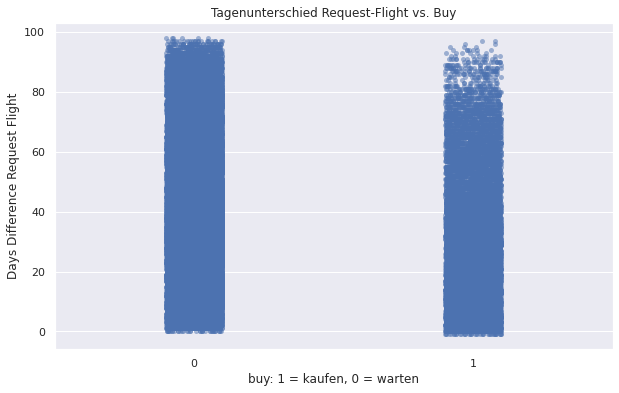

In [30]:
plt.figure(figsize=(10, 6))
sns.stripplot(data=flug_df, x='buy', y='days_diff_Req_Flight', jitter=True, alpha=0.5)
plt.xlabel('buy: 1 = kaufen, 0 = warten')
plt.ylabel('Days Difference Request Flight')
plt.title('Tagenunterschied Request-Flight vs. Buy')
plt.show()

Das Streudiagramm zeigt, dass es eine gewisse Tendenz gibt, dass Flüge mit einem kürzeren Zeitunterschied zwischen Anfrage und Flug eher gekauft werden. Allerdings gibt es auch einige Abweichungen von dieser Tendenz, da es Situationen gibt, in denen Flüge mit einem längeren Zeitunterschied gekauft wurden.

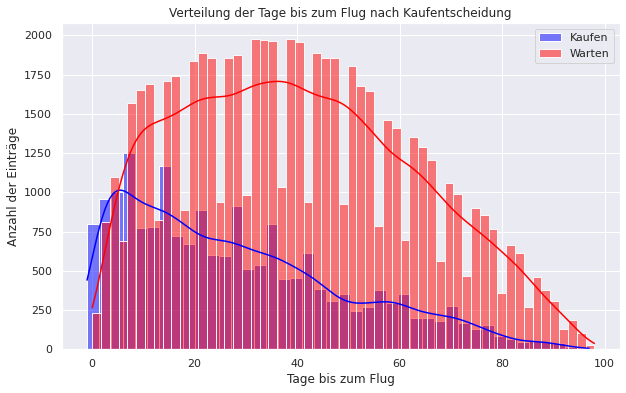

In [31]:
plt.figure(figsize=(10, 6))

# Verteilung der Tage bis zum Flug für die Kategorie 'Kaufen'
sns.histplot(Trainingsdaten[Trainingsdaten['buy'] == 1]['days_diff_Req_Flight'], kde=True, color= 'blue', label='Kaufen')

# Verteilung der Tage bis zum Flug für die Kategorie 'Warten'
sns.histplot(Trainingsdaten[Trainingsdaten['buy'] == 0]['days_diff_Req_Flight'], kde=True, color='red', label='Warten')

plt.title('Verteilung der Tage bis zum Flug nach Kaufentscheidung')
plt.xlabel('Tage bis zum Flug')
plt.ylabel('Anzahl der Einträge')
plt.legend()
plt.show()


Diese Histogramme zeigen die Verteilung der Tage zwischen der Anfrage und dem Flugdatum (Tage bis zum Flug) für zwei Kategorien: Kaufen (Blau) und Warten (Rot).

- Kaufen: Die blaue Kurve zeigt, dass die Kunden eher dazu neigen, Tickets zu kaufen, wenn das Flugdatum näher ist. Dies wird durch den höheren Peak der blauen Kurve im Bereich von 0 bis 20 Tagen verdeutlicht.
- Warten: Die rote Kurve zeigt, dass die Kunden eher dazu neigen, mit dem Kauf zu warten, wenn das Flugdatum weiter entfernt ist. Dies wird durch die höheren Peaks der roten Kurve im Bereich von 20, 40 und 60 Tagen verdeutlicht.

Die große Überlappung zwischen den beiden Kurven zeigt allerdings, dass die Anzahl der Tage bis zum Flug allein nicht ausreicht, um eine genaue Kaufentscheidung vorherzusagen. Es gibt viele Fälle, in denen Kunden sich entscheiden zu kaufen, auch wenn das Flugdatum noch weit entfernt ist, und umgekehrt, in denen sie sich entscheiden zu warten, obwohl das Flugdatum näher rückt. 

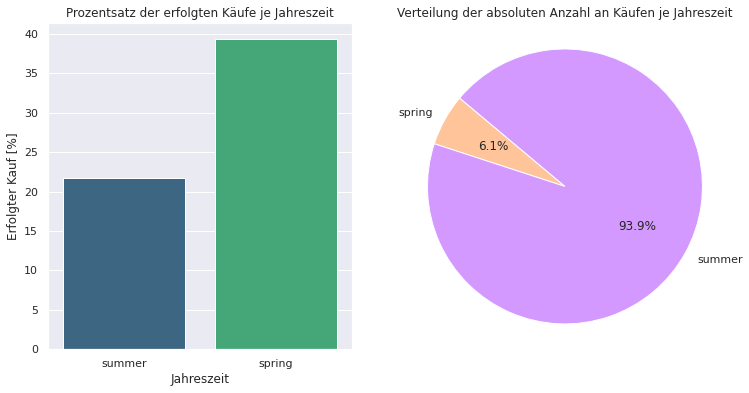

In [32]:
 # Berechnungen für die Diagramme
buy_percentage_by_season = Trainingsdaten.groupby('season')['buy'].mean() * 100
sorted_seasons = buy_percentage_by_season.sort_values().index
buy_counts_by_season = Trainingsdaten.groupby('season')['buy'].sum()

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Barplot
sns.barplot(x=sorted_seasons, y=buy_percentage_by_season[sorted_seasons], palette='viridis', ax=ax[0])
ax[0].set_title('Prozentsatz der erfolgten Käufe je Jahreszeit')
ax[0].set_ylabel('Erfolgter Kauf [%]')
ax[0].set_xlabel('Jahreszeit')

# Pie Chart
colors = ['#ffc499','#d499ff'] 
ax[1].pie(buy_counts_by_season, labels=buy_counts_by_season.index, autopct='%1.1f%%', startangle=140, colors=colors)
ax[1].axis('equal') 
ax[1].set_title('Verteilung der absoluten Anzahl an Käufen je Jahreszeit')

plt.show()


Diese Diagramme zeigen die Verteilung und den Prozentsatz der Kaufentscheidungen ("buy") nach Jahreszeiten.

Das linke Diagramm (ein Balkendiagramm) zeigt den Prozentsatz der erfolgten Käufe je Jahreszeit. Hier sehen wir, dass der Kaufprozentsatz im Frühling bei etwa 40% liegt und im Sommer bei etwa 22%. Das bedeutet, dass ein höherer Anteil der Fluganfragen im Frühling zu einem Kauf führt, während im Sommer ein geringerer Anteil der Anfragen zu einem Kauf führt.

Das rechte Diagramm (ein Tortendiagramm) zeigt die Verteilung der absoluten Anzahl an Käufen je Jahreszeit. Hier sehen wir, dass die überwiegende Mehrheit der Käufe (etwa 93,9%) im Sommer getätigt wird, während nur eine kleine Minderheit der Käufe (etwa 6,1%) im Frühling getätigt wird.

Diese beiden Diagramme zusammen liefern eine interessante Erkenntnis: obwohl der Prozentsatz der Käufe im Frühling höher ist (d.h., ein größerer Anteil der Anfragen führt zu einem Kauf), ist die absolute Anzahl der Käufe im Sommer deutlich höher. Dies könnte auf eine höhere Gesamtnachfrage nach Flügen im Sommer hinweisen, trotz der Tatsache, dass ein geringerer Anteil dieser Anfragen zu einem Kauf führt.

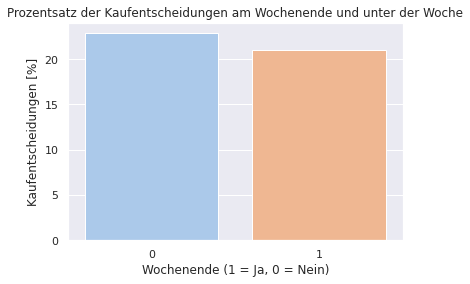

In [33]:
# Berechnung des Prozentsatzes der Kaufentscheidungen für jede Kategorie der 'weekend'-Variable
weekend_buy_percentage = Trainingsdaten.groupby('weekend')['buy'].mean() * 100

plt.figure(figsize=(6, 4))
sns.barplot(x=weekend_buy_percentage.index, y=weekend_buy_percentage, palette='pastel')
plt.title('Prozentsatz der Kaufentscheidungen am Wochenende und unter der Woche')
plt.ylabel('Kaufentscheidungen [%]')
plt.xlabel('Wochenende (1 = Ja, 0 = Nein)')
plt.show()

Das Diagramm zeigt den Prozentsatz der Kaufentscheidungen am Wochenende und unter der Woche. Der geringe Unterschied deutet darauf hin, dass der Wochentag (Wochenende oder nicht) keinen großen Einfluss auf die Kaufentscheidungen hat. Dies könnte bedeuten, dass diese Variable für Vorhersagemodelle weniger relevant sein könnte.

## Daten trennen in Features und Zielvariablen


In [34]:
 Feature = [ 'Price_In_Eur',
       'season', 'Request_Dayofweek', 'Request_month', 'days_diff_Req_Flight',
       'Flight_Dayofweek', 'Flight_month', 'Flight_weekofyear', 'weekend',
       'departure_time', 'Request_time', 'source', 'destination',
       'Price_In_Eur_max', 'Price_In_Eur_min', 'Price_In_Eur_mean',
       'Number_of_Request']
    
def get_X_y(Trainingsdaten):
    X = Trainingsdaten[Feature]
    y = Trainingsdaten['buy']
    groups = Trainingsdaten['flight_unique_id']
    return X,y,groups


X_test = Testdaten[Feature]

In [35]:
X,y,Groups = get_X_y(Trainingsdaten)

sgk =StratifiedGroupKFold(n_splits=10, shuffle=True, random_state=42)

def get_train_val_daten(X,y,Groups):
    for train_idx,val_idx in sgk.split(X,y,Groups):
        X_train = X.loc[train_idx]
        y_train = y.loc[train_idx]
        X_val = X.loc[val_idx]
        y_val = y.loc[val_idx]
    return X_train,y_train,X_val,y_val

X_train,y_train,X_val,y_val = get_train_val_daten(X,y,Groups)


## Feature processing
### Normalisierung von numerischen Merkmalen und binäre Kodierung                                      von nominalen Merkmalen

In [36]:
# Merkmale für numerische Transformation
numeric_features = ['Price_In_Eur','Price_In_Eur_max','Price_In_Eur_min','Price_In_Eur_mean','Number_of_Request',
                   'days_diff_Req_Flight','weekend','Request_Dayofweek','Request_month',
                    'Flight_Dayofweek','Flight_month','Flight_weekofyear']

# Merkmale für kategoriale Transformation
categorical_features = ['season','departure_time','Request_time','source','destination']

# Preprocessing-Schritte für numerische Merkmale
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# Preprocessing-Schritte für kategoriale Merkmale
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first',handle_unknown='ignore'))])

# ColumnTransformer für die kombinierte Transformation der Merkmale
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])



# Transformation der Merkmale im X_train
Xtrain_transformed = preprocessor.fit_transform(X_train)
# Überschriften der transformierten Merkmale erhalten
transformed_feature_names_train = preprocessor.get_feature_names_out()

# Transformation der Merkmale im X_val
Xval_transformed = preprocessor.transform(X_val)
# Überschriften der transformierten Merkmale erhalten
transformed_feature_names_val = preprocessor.get_feature_names_out()

# Transformation der Merkmale im X_test
Xtest_transformed = preprocessor.transform(X_test)
# Überschriften der transformierten Merkmale erhalten
transformed_feature_names_test = preprocessor.get_feature_names_out()


In [37]:
# neue Dataframe für Trainingsdaten mit transformierten Merkmalen
frame_train = pd.DataFrame(Xtrain_transformed,columns=preprocessor.get_feature_names_out())
frame_train.shape

(75191, 21)

In [38]:
# neue Dataframe für Validierungsdaten mit transformierten Merkmalen
frame_val = pd.DataFrame(Xval_transformed,columns=transformed_feature_names_val)
frame_val.shape

(8433, 21)

In [39]:
# neue Dataframe für Testdaten mit transformierten Merkmalen
frame_test = pd.DataFrame(Xtest_transformed,columns=transformed_feature_names_test)
frame_test.shape

(5583, 21)

## Features Selection (Zielvariable= Buy)

In diesem Abschnitt verwenden wir zwei Methoden: **SelectKBest** und **Recursive Feature Elimination**. Diese dienen dazu, die wichtigsten Merkmale für das Vorhersagemodell zu ermitteln.

- ### Mit Selectkbest 

In [40]:
#Anzahl gewünschte Feature
k=15

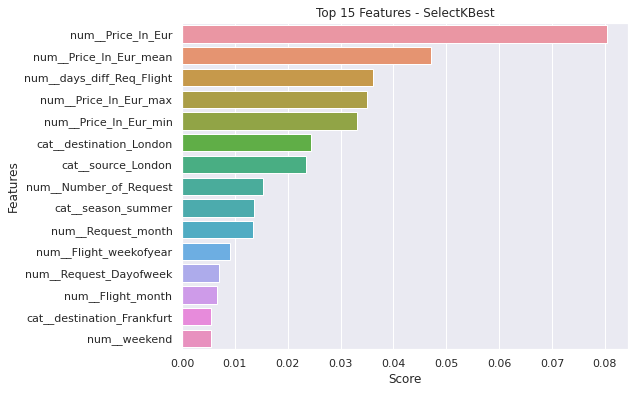

In [41]:

# SelectKBest-Transformer mit der gewünschten Score-Funktion erstellen
kbest = SelectKBest(score_func= mutual_info_classif, k=k) #als Score_Finktion haben wir uns für mutual_info_classif entschieden.
                                                          #Der Hauptgrund dafür ist, dass mutual_info_classif 
                                                          #auf der "mutual information" zwischen den Features und 
                                                          #der Zielklasse basiert, unabhängig von der Verteilung der Klassen. 
                                                          #Dies bedeutet, dass es die Abhängigkeit zwischen den Features und 
                                                          #der Zielklasse berücksichtigt,
                                                          #ohne von der Klassenverteilung beeinflusst zu werden.

# Transformer auf die Daten anwenden 
Xtrain_selected = kbest.fit_transform(Xtrain_transformed, y_train)

# Die ausgewählten Feature-Indizes erhalten
feature_indices = kbest.get_support(indices=True)

# Die Namen der ausgewählten Features erhalten
selected_features = frame_train.columns[feature_indices]

#Score
feature_scores = kbest.scores_

# Erstelle ein Array mit den Rängen der Features (absteigend sortiert)
top_15_features = np.argsort(feature_scores)[-k::][::-1] 

# Sortiere die Features nach ihrem Score
sorted_scores = np.sort(feature_scores)[-k::][::-1]  
sorted_names = np.array(transformed_feature_names_train)[top_15_features]

# Plotte die Scores der k besten Features
plt.figure(figsize=(8,6))
sns.barplot(x=sorted_scores, y=sorted_names)
plt.xlabel('Score')
plt.ylabel('Features')
plt.title(f'Top {k} Features - SelectKBest')
plt.show()

Daraus können wir sagen, dass die Features "num_Price_In_Eur", "num_Price_In_Eur_mean", "num_Price_In_Eur_max", "num_days_diff_Req_Flight" und "num_Price_in_Eur_min" die Top 5 der wichtigsten Merkmale sind. Diese Merkmale sind größtenteils abgeleitete Features des Merkmals "Price_In_Eur" aus der ursprünglichen CSV-Datei.

- ### Mit RFECV (Recursive Feature Elimination Cross Validation)

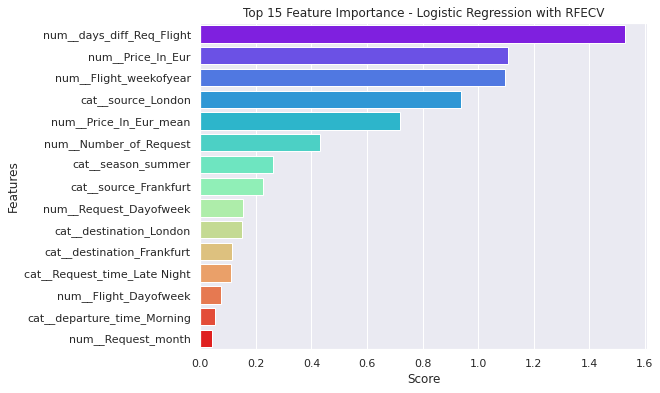

In [42]:
# Erstelle das Basismodell
base_model = LogisticRegression(random_state=42, n_jobs = 8)

# Erstelle RFECV (RFE mit Kreuzvalidierung), um die optimale Anzahl von Merkmalen zu ermitteln
rfecv = RFECV(estimator=base_model, step=1, min_features_to_select = k, cv=10, scoring='accuracy')

# Das Modell anpassen
rfecv.fit(Xtrain_transformed, y_train)

# Die optimalen Merkmale auswählen
Xtrain_selected = Xtrain_transformed[:, rfecv.support_]

# Die Namen der ausgewählten Features erhalten
selected_features_rfecv = frame_train.columns[rfecv.support_]

# Trainiere das Basismodell erneut mit den ausgewählten Features
base_model.fit(Xtrain_selected, y_train)

# Feature importance scores aus dem Modell extrahieren
importance_scores = np.abs(base_model.coef_[0])

# Erstelle ein DataFrame für eine bessere Visualisierung
data = {'Features': selected_features_rfecv, 'Importance': importance_scores}
df = pd.DataFrame(data)

# Sortiere die Daten nach der Wichtigkeit der Features
df = df.sort_values(by='Importance', ascending=False)

# Erstelle die colormap
colors = cm.rainbow(np.linspace(0, 1, len(df)))

# Plotte die Wichtigkeit der Top-15-Features
plt.figure(figsize=(8,6))
sns.barplot(x='Importance', y='Features', data=df, palette=colors)  
plt.xlabel('Score')
plt.ylabel('Features')
plt.title('Top 15 Feature Importance - Logistic Regression with RFECV')
plt.show()

Daraus lässt sich ableiten, dass die Merkmale 'num_days_diff_Req_Flight', 'num_Price_In_Eur', 'num_Flight_weekofyear', 'cat_source_London' und 'num_Price_In_Eur_mean' die fünf wichtigsten Faktoren darstellen. Diese Auswahl ähnelt stark der Auswahl durch die SelectKBest-Methode, wobei drei von fünf Top-Merkmalen übereinstimmen. Jedoch liegt das Merkmal 'num_Flight_weekofyear' bei der SelectKBest-Methode auf Platz 11, während es bei RFECV zu den Top 3 gehört. Außerdem befindet sich das Merkmal 'num_Price_In_Eur_min' in den Top 5 der SelectKBest-Methode, taucht jedoch nicht in den Top 15 von RFECV auf.

## Baseline

In diesem Fall nimmt das Baseline-Modell an, dass alle Vorhersagen Klasse "0" sind.

In [43]:
print(f'Trainingsdaten-Genauigkeit(Ohne Anpassung der Daten): {accuracy_score(y_train,np.zeros_like(y_train))}')

Trainingsdaten-Genauigkeit(Ohne Anpassung der Daten): 0.7765823037331595


Die Genauigkeit von etwa 77,43% zeigt, dass in 77,43% der Trainingsdaten die tatsächliche Klasse "0" ist. Dieses Baseline-Modell dient als Benchmark: Ein nützliches Modell sollte in der Lage sein, eine höhere Genauigkeit zu erzielen.

## Evaluierung und Vergleich von verschiedener Methoden zur Feature-Selection

### Kreuzvalidierung ohne Hyperparameter-Optimierung

Alle zwei ausgewählten Modelle gehören zu den Ensembled-Modellen und speziell zur Familie der Gradient Boosting Modelle. Jedes Modell weist spezifische Spezialisierungen und Stärken auf:

- **XGBoost** wird für seine Robustheit und Genauigkeit geschätzt. Es setzt verschiedene Regularisierungstechniken ein, um Overfitting zu vermeiden und die allgemeine Leistung des Modells zu verbessern.

- **CatBoost** zeigt seine Stärken, wenn der Datensatz viele kategoriale Merkmale aufweist. Dank einer speziellen Codierungstechnik für kategoriale Variablen kann es die Vorhersageleistung deutlich verbessern.

Diese Modelle sind besonders gut für Klassifikationsaufgaben geeignet. Jedoch sollte beachtet werden, dass ihr Einsatz im Vergleich zu einfacheren Modellen möglicherweise mehr Rechenzeit und Speicher erfordert.

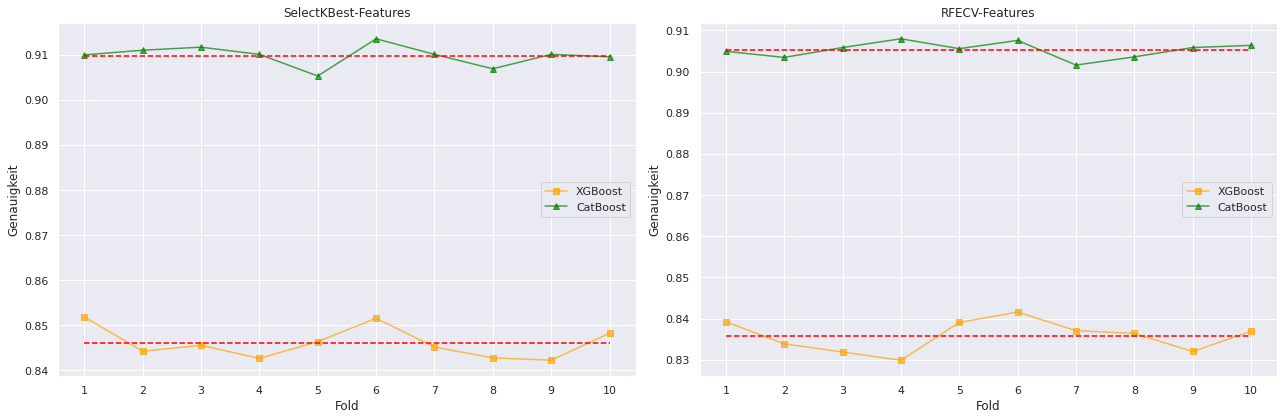

Mittlere Kreuzvalidierungs-Genauigkeit bei Traningsdatensatz mit SelectKBest-Features für XGBoost: 0.8460852259382614
Mittlere Kreuzvalidierungs-Genauigkeit bei Traningsdatensatz mit RFECV-Features für XGBoost: 0.8358047715291474
Mittlere Kreuzvalidierungs-Genauigkeit bei Traningsdatensatz mit SelectKBest-Features für CatBoost: 0.9098296319536606
Mittlere Kreuzvalidierungs-Genauigkeit bei Traningsdatensatz mit RFECV-Features für CatBoost: 0.9052679223272675
CPU times: user 10min 10s, sys: 1min 28s, total: 11min 39s
Wall time: 1min 42s


In [44]:
%%time

# Setzen Feature-Namen
selectkbest_features = selected_features  
selectrfecv_features = selected_features_rfecv 

# Anzahl der CPU-Kerne ermitteln
n_jobs = 8

# Kreieren den StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Kreiere leere Listen zum Speichern der Kreuzvalidierungs-Genauigkeiten und Trainingszeiten für jedes Modell und jede Feature-Auswahlmethode
cv_scores_selectkbest = []
cv_scores_rfecv = []

# Erstelle eine Liste mit den Modellen und ihren entsprechenden Labels für die Legende, Farben und Marker
models = [
    (XGBClassifier(n_jobs=n_jobs), 'XGBoost', 'orange', 's'),
    (CatBoostClassifier(verbose=False, thread_count=n_jobs), 'CatBoost', 'green', '^')  # Wir setzen verbose=False, um die CatBoost-Ausgabe zu unterdrücken.
]

# Iteriere über jedes Modell und führe die Kreuzvalidierung durch
for model, label, color, marker in models:
    
    # Kreuzvalidierung mit SelectKBest-Features
    cv_scores_model_kbest = cross_val_score(model, frame_train[selectkbest_features], y_train, cv=stratified_kfold)
    
    # Speichere die Kreuzvalidierungs-Genauigkeiten für SelectKBest in der Liste
    cv_scores_selectkbest.append(cv_scores_model_kbest)

    # Kreuzvalidierung mit RFECV-Features
    cv_scores_model_rfecv = cross_val_score(model, frame_train[selectrfecv_features], y_train, cv=stratified_kfold)
    
    # Speichere die Kreuzvalidierungs-Genauigkeiten für RFECV in der Liste
    cv_scores_rfecv.append(cv_scores_model_rfecv)

# Erstelle eine Abbildung und Achsen für Subplots
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Iteriere über jedes Modell und plotte die Kreuzvalidierungs-Genauigkeiten für SelectKBest
for i, (model, label, color, marker) in enumerate(models):
    axs[0].plot(np.arange(1, 11), cv_scores_selectkbest[i], color=color, alpha=0.7, marker=marker, label=label)
    axs[0].plot(np.arange(1, 11), [np.mean(cv_scores_selectkbest[i])] * 10, linestyle='--', color='red')
    axs[0].set_title('SelectKBest-Features')
    axs[0].set_xlabel('Fold')
    axs[0].set_ylabel('Genauigkeit')
    axs[0].set_xticks(np.arange(1, 11))

# Iteriere über jedes Modell und plotte die Kreuzvalidierungs-Genauigkeiten für RFECV
for i, (model, label, color, marker) in enumerate(models):
    axs[1].plot(np.arange(1, 11), cv_scores_rfecv[i], color=color, alpha=0.7, marker=marker, label=label)
    axs[1].plot(np.arange(1, 11), [np.mean(cv_scores_rfecv[i])] * 10, linestyle='--', color='red')
    axs[1].set_title('RFECV-Features')
    axs[1].set_xlabel('Fold')
    axs[1].set_ylabel('Genauigkeit')
    axs[1].set_xticks(np.arange(1, 11))

# Legenden hinzufügen
axs[0].legend()
axs[1].legend()

# Anzeigen der Abbildung
plt.tight_layout()
plt.show()

# Gib die mittleren Kreuzvalidierungs-Genauigkeiten und Trainingszeiten für jedes Modell und jede Feature-Auswahlmethode aus
for i, (model, label, color, marker) in enumerate(models):
    print(f'Mittlere Kreuzvalidierungs-Genauigkeit bei Traningsdatensatz mit SelectKBest-Features für {label}: {np.mean(cv_scores_selectkbest[i])}')
    print(f'Mittlere Kreuzvalidierungs-Genauigkeit bei Traningsdatensatz mit RFECV-Features für {label}: {np.mean(cv_scores_rfecv[i])}')

Basierend auf den durchschnittlichen Ergebnissen der Kreuzvalidierungsgenauigkeit haben wir uns entschieden, die besten Merkmale aus der SelectKBest-Methode für die Modellanpassung zu verwenden. Die höheren Genauigkeitswerte durch die SelectKBest-Methode deuten darauf hin, dass die ausgewählten Merkmale einen größeren Einfluss auf die Modellleistung haben und besser geeignet sind, die Daten zu repräsentieren. Dies ermöglicht uns ein robustes Modell zu erstellen, das weniger anfällig für Overfitting ist und gut auf neue, unbekannte Daten generalisieren kann.

Es ist jedoch wichtig zu betonen, dass dies zunächst eine Auswahl auf Grundlage der Kreuzvalidierungsergebnisse ist. Um sicherzustellen, dass unser Modell die bestmögliche Leistung erbringt, sollten wir es weiter optimieren und verschiedene Hyperparameter-Anpassungen durchführen. Zudem sollten wir auch andere Evaluierungsmetriken berücksichtigen.

## Modellanpassung mit Trainingsdaten und Berechnung der Genauigkeit auf Trainings- und Validierungsdaten

- ### XGBoost

#### *Finden der besten Hyperparameter für XGBoost Modell mit RandomizedSearchCV*

In [45]:
%%time
# Initialisiere den XGBoost-Klassifikator mit Standardparametern
clf_xgb = XGBClassifier(n_jobs = 8, eval_metric='logloss', random_state = 42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [2, 5],
    'learning_rate': [0.01, 0.2],
    'gamma': [0.4, 0.5],
    'min_child_weight': [1, 3],
    'subsample': [0.5, 0.8],
    'colsample_bytree': [0.4, 0.6],
    'reg_alpha': [0, 2],
    'reg_lambda': [4, 5]
}

# Initialisiere StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Initialisiere RandomizedSearchCV mit StratifiedKFold
random_search = RandomizedSearchCV(estimator=clf_xgb, param_distributions=param_grid, 
                                   n_iter=10, cv=stratified_kfold, random_state=42)

# Führe die Zufallssuche durch
X_train_selected = frame_train[selectkbest_features]
random_search.fit(X_train_selected, y_train)

# die besten Parameter ausgeben
print('Best parameters:', random_search.best_params_)

Best parameters: {'subsample': 0.5, 'reg_lambda': 4, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.2, 'gamma': 0.4, 'colsample_bytree': 0.6}
CPU times: user 18min 4s, sys: 2.83 s, total: 18min 7s
Wall time: 2min 21s


#### *Traning mit besten Parameter auf Traningsdaten und Validierungsdaten*

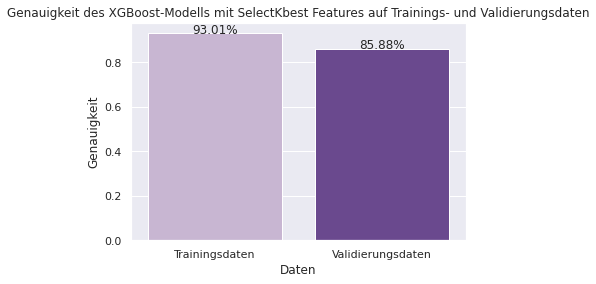

Genauigkeit mit SelectKbest-Features auf den Trainingsdaten: 0.9301113165139445
Genauigkeit mit SelectKbest-Features auf den Validierungsdaten: 0.8587691213091426


In [46]:
# Modell erstellen mit den besten Hyperparametern
clf_xgb = XGBClassifier(
    n_jobs=4, 
    verbosity=0, 
    random_state = 42,
    eval_metric='logloss',
    reg_lambda=4,  
    reg_alpha=0, 
    n_estimators=300, 
    min_child_weight=3, 
    max_depth=5,  
    learning_rate=0.2, 
    gamma=0.4,
    subsample = 0.5,
    colsample_bytree = 0.6
)

# Modell trainieren mit RFE-Features 
clf_xgb.fit(frame_train[selectkbest_features], y_train)

# Vorhersagen und Genauigkeiten berechnen
y_pred_train_xgb = clf_xgb.predict(frame_train[selectkbest_features])
y_pred_val_xgb = clf_xgb.predict(frame_val[selectkbest_features])
accuracy_train_xgb = accuracy_score(y_train, y_pred_train_xgb)
accuracy_val_xgb = accuracy_score(y_val, y_pred_val_xgb)

colors = sns.color_palette("Paired", 10)[8:10]
def plot_accuracy(results, title):
    accuracy_data = pd.DataFrame.from_dict(results, orient='index', columns=['Genauigkeit'])
    ax = sns.barplot(x=accuracy_data.index, y=accuracy_data['Genauigkeit'], palette=colors)
    ax.set_xlabel('Daten')
    ax.set_ylabel('Genauigkeit')
    ax.set_title(title)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height,
                '{:1.2f}%'.format(height*100),
                ha="center") 
    plt.show()


# Ergebnisse in ein Dictionary einfügen
results = {'Trainingsdaten': accuracy_train_xgb, 'Validierungsdaten': accuracy_val_xgb}
plot_accuracy(results, 'Genauigkeit des XGBoost-Modells mit SelectKbest Features auf Trainings- und Validierungsdaten')

print(f'Genauigkeit mit SelectKbest-Features auf den Trainingsdaten: {accuracy_train_xgb}')
print(f'Genauigkeit mit SelectKbest-Features auf den Validierungsdaten: {accuracy_val_xgb}')

Training LogLoss:  0.184085
Validation LogLoss:  0.312351


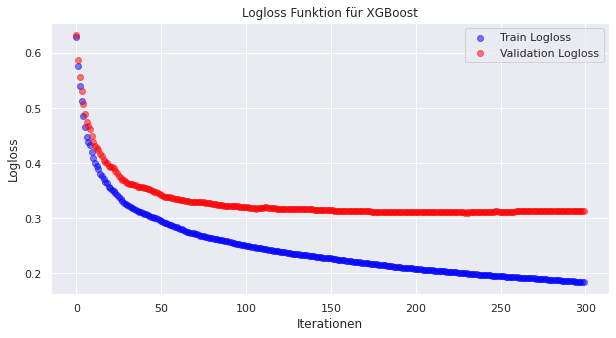

In [47]:
# Trainings- und Validierungsdatensätze
eval_set = [(frame_train[selectkbest_features], y_train), (frame_val[selectkbest_features], y_val)]

# Modell trainieren mit RFE-Features 
clf_xgb.fit(frame_train[selectkbest_features], y_train, eval_set=eval_set, verbose=False)

# Abrufen der Ergebnisse
results = clf_xgb.evals_result()
train_logloss_xgb = results['validation_0']['logloss']
val_logloss_xgb = results['validation_1']['logloss']

print('Training LogLoss: ', train_logloss_xgb[-1]) 
print('Validation LogLoss: ', val_logloss_xgb[-1])

# Erstellen von Iterationen-Arrays
iterations = np.arange(0, len(train_logloss_xgb))

# Erstellen einer Abbildung und Achsen
fig, ax = plt.subplots(figsize=(10,5))

# Hinzufügen der Trainingsdatenpunkte
ax.scatter(iterations, train_logloss_xgb, color='blue', alpha=0.5, label='Train Logloss')

# Hinzufügen der Validierungsdatenpunkte
ax.scatter(iterations, val_logloss_xgb, color='red', alpha=0.5, label='Validation Logloss')

# Titel und Beschriftungen hinzufügen
ax.set_title('Logloss Funktion für XGBoost')
ax.set_xlabel('Iterationen')
ax.set_ylabel('Logloss')

# Legende anzeigen
ax.legend()

# Diagramm anzeigen
plt.show()

- ### CATBoost

#### *Finden der besten Hyperparameter für Catboost Modell mit RandomizedSearchCV*

In [48]:
%%time
# Initialisiere den CatBoost-Klassifikator mit Standardparametern
clf_catboost = CatBoostClassifier(thread_count=8, verbose=False, eval_metric = 'Logloss', random_state = 42)

# Parametergitter für die zufällige Suche
param_grid = {
    'depth': [6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [100,200],
    'l2_leaf_reg': [3, 5, 7],
    'border_count': [20, 32, 50]
}


# Initialisiere StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Initialisiere RandomizedSearchCV mit StratifiedKFold
random_search = RandomizedSearchCV(estimator=clf_catboost, param_distributions=param_grid,
                                   n_iter=10, cv=stratified_kfold, random_state=42)

# Führe die Zufallssuche durch
X_train_selected = frame_train[selectkbest_features]
random_search.fit(X_train_selected, y_train)

# die besten Parameter ausgeben
print('Best parameters:', random_search.best_params_)


Best parameters: {'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 200, 'depth': 10, 'border_count': 32}
CPU times: user 9min 35s, sys: 2min 42s, total: 12min 17s
Wall time: 2min 27s


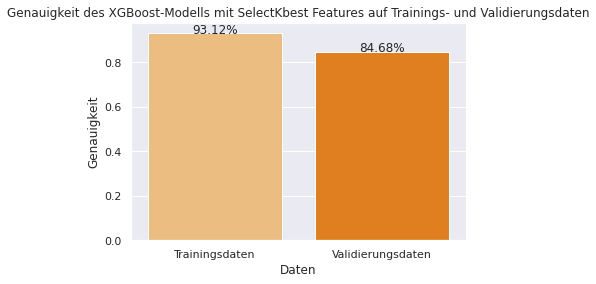

Genauigkeit mit SelectKbest-Features auf den Trainingsdaten: 0.9312417709566304
Genauigkeit mit SelectKbest-Features auf den Validierungsdaten: 0.8467923633345191


In [49]:
# Modellanpassung mit den besten Hyperparametern
clf_catboost = CatBoostClassifier(
    eval_metric='Logloss',
    learning_rate=0.1, 
    l2_leaf_reg=3,  
    depth=10, 
    iterations = 200,
    border_count=32, 
    thread_count = 8,
    verbose=0,
    random_state = 42
)

# Modell trainieren mit selectkbest-Features 
clf_catboost.fit(frame_train[selectkbest_features], y_train)

# Vorhersagen und Genauigkeiten berechnen
y_pred_train_catboost = clf_catboost.predict(frame_train[selectkbest_features])
y_pred_val_catboost = clf_catboost.predict(frame_val[selectkbest_features])
accuracy_train_catboost = accuracy_score(y_train, y_pred_train_catboost)
accuracy_val_catboost = accuracy_score(y_val, y_pred_val_catboost)

# Ergebnisse in ein Dictionary einfügen
results = {'Trainingsdaten': accuracy_train_catboost, 'Validierungsdaten': accuracy_val_catboost}
colors = sns.color_palette("Paired", 10)[6:8]
plot_accuracy(results, 'Genauigkeit des XGBoost-Modells mit SelectKbest Features auf Trainings- und Validierungsdaten')

print(f'Genauigkeit mit SelectKbest-Features auf den Trainingsdaten: {accuracy_train_catboost}')
print(f'Genauigkeit mit SelectKbest-Features auf den Validierungsdaten: {accuracy_val_catboost}')

Training LogLoss:  0.1912419262833115
Validation LogLoss:  0.3331074432307397


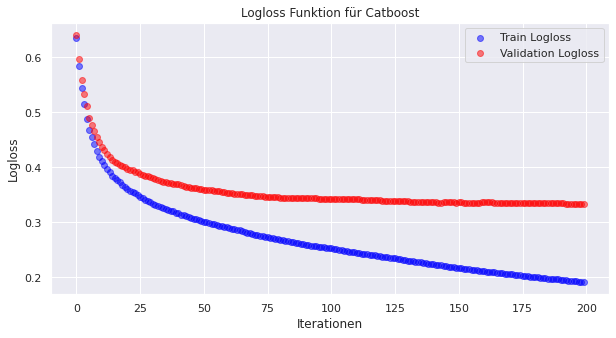

In [50]:
# Trainings- und Validierungsdatensätze
eval_set = [(frame_train[selectkbest_features], y_train), (frame_val[selectkbest_features], y_val)]

# Modell trainieren mit RFE-Features 
clf_catboost.fit(frame_train[selectkbest_features], y_train, eval_set=(frame_val[selectkbest_features], y_val), verbose=False)

# Abrufen der Ergebnisse
results = clf_catboost.get_evals_result()
train_logloss_cat = results['learn']['Logloss']
val_logloss_cat = results['validation']['Logloss']

print('Training LogLoss: ', train_logloss_cat[-1]) 
print('Validation LogLoss: ', val_logloss_cat[-1])

# Erstellen von Iterationen-Arrays
iterations = np.arange(0, len(train_logloss_cat))

# Erstellen einer Abbildung und Achsen
fig, ax = plt.subplots(figsize=(10,5))

# Hinzufügen der Trainingsdatenpunkte
ax.scatter(iterations, train_logloss_cat, color='blue', alpha=0.5, label='Train Logloss')

# Hinzufügen der Validierungsdatenpunkte
ax.scatter(iterations, val_logloss_cat, color='red', alpha=0.5, label='Validation Logloss')

# Titel und Beschriftungen hinzufügen
ax.set_title('Logloss Funktion für Catboost')
ax.set_xlabel('Iterationen')
ax.set_ylabel('Logloss')

# Legende anzeigen
ax.legend()

# Diagramm anzeigen
plt.show()


## Vergleich der Ergbenisse von zwei Modellen

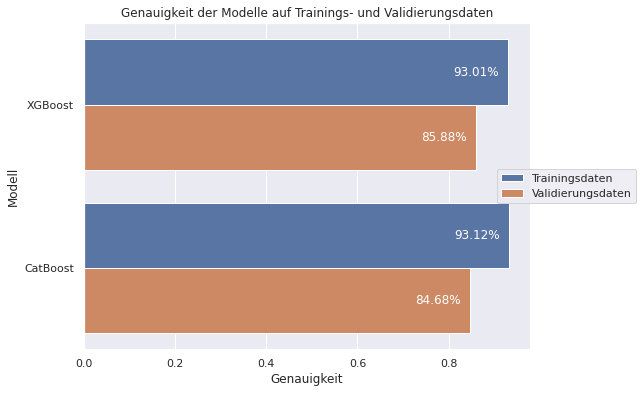

In [51]:
# die Genauigkeiten in Listen speichern
accuracy_train = [accuracy_train_xgb, accuracy_train_catboost]
accuracy_val = [ accuracy_val_xgb, accuracy_val_catboost]

# DataFrame für die Ergebnisse erstellen
df_results = pd.DataFrame({'Modell': [ 'XGBoost', 'CatBoost', 'XGBoost', 'CatBoost'],
                           'Genauigkeit': accuracy_train + accuracy_val,
                           'Daten': ['Trainingsdaten']*2 + ['Validierungsdaten']*2})

palette = sns.color_palette("deep")

# Barplot erstellen
plt.figure(figsize=(8,6))
ax = sns.barplot(x='Genauigkeit', y='Modell', hue='Daten', data=df_results, palette=palette)

for p in ax.patches:
    width = p.get_width() 
    plt.text(width-0.02,     
             p.get_y() + p.get_height() / 2,
             '{:1.2f}%'.format(width*100),  
             color='white', 
             ha="right", 
             va="center")

plt.title('Genauigkeit der Modelle auf Trainings- und Validierungsdaten')
plt.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.show()

Aus den Ergebnissen lässt sich ableiten, dass beide Modelle ähnliche Leistung zeigen. Die Genauigkeit auf den Trainingsdaten liegt für beide Modelle bei über 90%, während sie auf den Validierungsdaten bei ca 85% liegt. Die Unterschiede zwischen den beiden Modellen sind nicht signifikant.

Diese Ergebnisse deuten darauf hin, dass trotz geringfügiger Unterschiede in der Leistung alle zwei Modelle eine hohe Genauigkeit aufweisen und gut für diese Art von Klassifizierungsaufgaben geeignet sind. Es wäre zudem aufschlussreich, weitere Metriken wie Präzision, Sensitivität (Recall) oder den F1-Score zu berücksichtigen, um ein umfassenderes Bild der Modellleistung zu erhalten.

### Präzision, Recall, F1-Score, ROC-Kurve auf Validierungsdaten

- ### XGBoost

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      6514
           1       0.75      0.57      0.65      1919

    accuracy                           0.86      8433
   macro avg       0.81      0.76      0.78      8433
weighted avg       0.85      0.86      0.85      8433



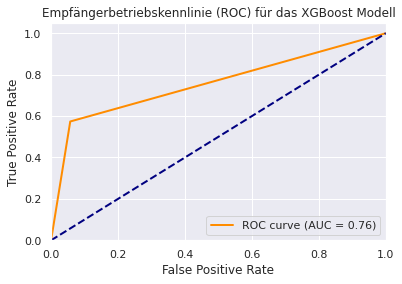

In [52]:
# Präzision, Recall, F1-Score berechnen

print(classification_report(y_val, y_pred_val_xgb))

# ROC-Kurve und AUC berechnen
fpr, tpr, thresholds = roc_curve(y_val, y_pred_val_xgb)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Empfängerbetriebskennlinie (ROC) für das XGBoost Modell')
plt.legend(loc="lower right")
plt.show()

- ### Catboost

              precision    recall  f1-score   support

           0       0.87      0.94      0.90      6514
           1       0.73      0.53      0.61      1919

    accuracy                           0.85      8433
   macro avg       0.80      0.73      0.76      8433
weighted avg       0.84      0.85      0.84      8433



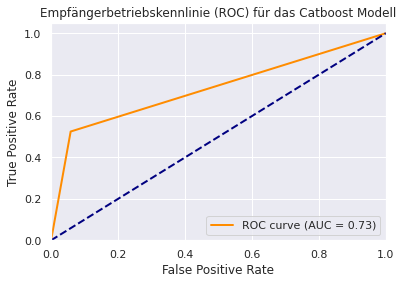

In [53]:
# Präzision, Recall, F1-Score berechnen

print(classification_report(y_val, y_pred_val_catboost))

# ROC-Kurve und AUC berechnen
fpr, tpr, thresholds = roc_curve(y_val, y_pred_val_catboost)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Empfängerbetriebskennlinie (ROC) für das Catboost Modell')
plt.legend(loc="lower right")
plt.show()

Das XGBoost- und das CatBoost-Modell zeigen jeweils eine Genauigkeit von 86% und 85% auf den Validierungsdaten. Bei näherer Betrachtung der Präzision für die einzelnen Klassen fällt jedoch auf, dass beide Modelle eine höhere Präzision für die Klasse 0 als für die Klasse 1 aufweisen. Dies könnte darauf hindeuten, dass beide Modelle tendenziell mehr Instanzen der Klasse 0 zuordnen, was zu einer erhöhten Anzahl an falsch positiven Vorhersagen führt.

In Bezug auf die Fläche unter der ROC-Kurve (AUC) performen die Modelle etwas unterschiedlich. Das XGBoost-Modell erreicht einen AUC-Wert von 0,76, während CatBoost einen AUC-Wert von 0,73 erzielt. Dies zeigt, dass das XGBoost-Modell insgesamt eine bessere Leistung bei der Unterscheidung zwischen den Klassen erbringt.

## Vorhersage des Testdatensatzes

### XGBoost

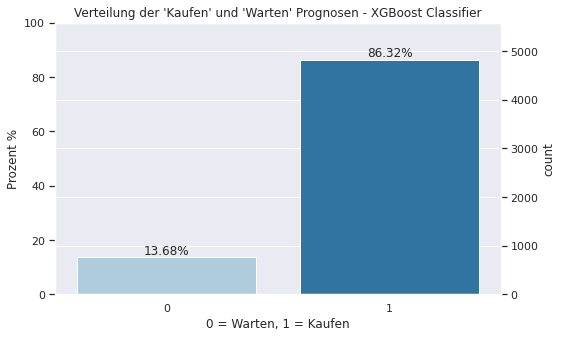

In [54]:
# Vorhersagen für Testdaten machen
pred_test_xgb = clf_xgb.predict(frame_test[selectkbest_features])
pred_prob_xgb = clf_xgb.predict_proba(frame_test[selectkbest_features])[:,1]

# Die Vorhersagen in der DataFrame speichern
flug_df_test['buy_xgb'] = pred_test_xgb

def visualization(column, title):
    ncount = len(flug_df_test)

    ax2=ax.twinx()

    ax2.yaxis.tick_left()
    ax.yaxis.tick_right()

    ax.yaxis.set_label_position('right')
    ax2.yaxis.set_label_position('left')

    ax2.set_ylabel('Prozent %')
    plt.title(title)

    for i in ax.patches:
        x=i.get_bbox().get_points()[:,0]
        y=i.get_bbox().get_points()[1,1]
        ax.annotate('{:.2f}%'.format(100.*y/ncount), (x.mean(), y), 
                ha='center', va='bottom')

    ax2.set_ylim(0,100)
    ax2.grid(None)

ax = sns.countplot(x=flug_df_test['buy_xgb'], palette="Paired")
sns.set(font_scale=1.)
ax.set_ylim(top=len(flug_df_test))
ax.set_xlabel('0 = Warten, 1 = Kaufen')
fig = plt.gcf()
fig.set_size_inches(8,5)

visualization('buy_xgb', "Verteilung der 'Kaufen' und 'Warten' Prognosen - XGBoost Classifier")

plt.show()

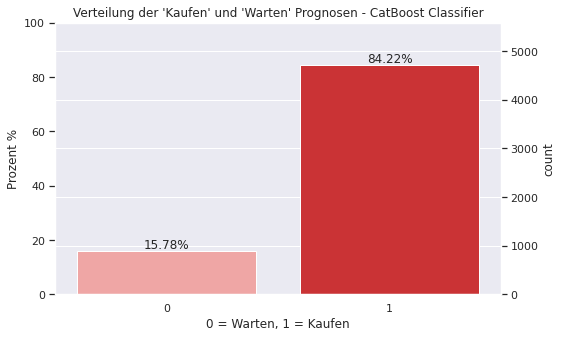

In [55]:
# Vorhersagen für Testdaten machen
pred_test_cat = clf_catboost.predict(frame_test[selectkbest_features])
pred_prob_cat = clf_catboost.predict_proba(frame_test[selectkbest_features])[:,1]

# Die Vorhersagen in der DataFrame speichern
flug_df_test['buy_cat'] = pred_test_cat

colors = sns.color_palette("Paired")[4:6]
ax = sns.countplot(x=flug_df_test['buy_cat'], palette= colors)
sns.set(font_scale=1.)
ax.set_ylim(top=len(flug_df_test))
ax.set_xlabel('0 = Warten, 1 = Kaufen')
fig = plt.gcf()
fig.set_size_inches(8,5)

visualization('buy_cat', "Verteilung der 'Kaufen' und 'Warten' Prognosen - CatBoost Classifier")

plt.show()

### Vergleich der Ergebnisse von zwei Modellen

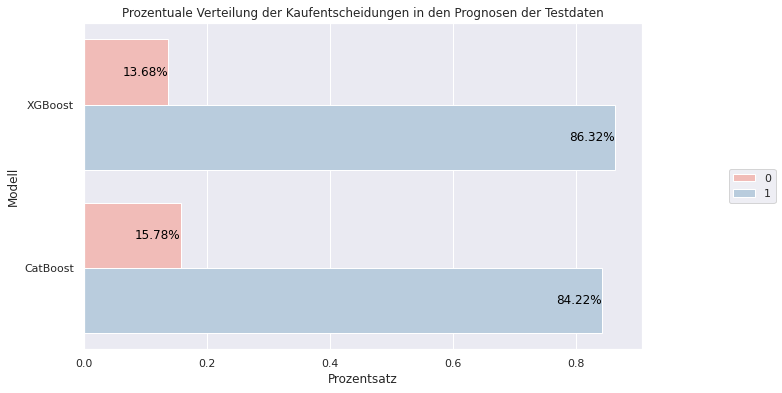

In [56]:
# "buy"-Werte zählen für jedes Modell

counts_xgb = flug_df_test['buy_xgb'].value_counts(normalize=True)
counts_cat = flug_df_test['buy_cat'].value_counts(normalize=True)

# DataFrame für die Ergebnisse erstellen
df_results_test = pd.DataFrame({
    'Modell': ['XGBoost']*len(counts_xgb) + ['CatBoost']*len(counts_cat),
    'Kaufentscheidung':  list(counts_xgb.index) + list(counts_cat.index),
    'Prozentsatz':  list(counts_xgb.values) + list(counts_cat.values)
})

palette = sns.color_palette("Pastel1", df_results_test['Modell'].nunique())

# Barplot erstellen
plt.figure(figsize=(10,6))
ax = sns.barplot(x='Prozentsatz', y='Modell', hue='Kaufentscheidung', data=df_results_test, palette=palette)

for p in ax.patches:
    width = p.get_width() 
    plt.text(width,     
             p.get_y() + p.get_height() / 2,
             '{:1.2f}%'.format(width*100),  
             color='black', 
             ha="right", 
             va="center")

plt.title('Prozentuale Verteilung der Kaufentscheidungen in den Prognosen der Testdaten')
plt.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.show()


## Berechnung des monetären Maßes 

- ### Evaluation Function

In [57]:
# The model quality evaluation function expects a Pandas dataframe with at least the following columns:
# Request_Date          int64
# flight_unique_id     object
# Price               float64
# buy                 bool


def model_quality_evaluation(df):
    # Make a copy of the provided dataframe as to not modify the original.
    df = df.copy()

    # Convert 'Price' to whole cents and store as integers to avoid floating point errors.
    df['Price_In_Eur'] = df['Price_In_Eur'] * 100
    df['Price_In_Eur'] = df['Price_In_Eur'].astype(int)

    # Initialize a variable that stores the sum of all our balances.
    sum_balances = 0

    # Get a list of all 'flight_unique_id'.
    flight_unique_ids = df['flight_unique_id'].unique()

    # Iterate over all 'flight_unique_id'.
    for flight_unique_id in flight_unique_ids:
        # Get a subset of the data for the specified 'flight_unique_id'.
        df_subset = df[df['flight_unique_id'] == flight_unique_id]

        # Get all request dates except for the latest request date before departure.
        # At the latest request date before departure we need to buy a ticket anyway,
        # so we don't care about this specific request date.
        request_dates = df_subset[df_subset['Request_Date'] != df_subset['Request_Date'].max()]

        # Make sure request dates are sorted in descending order.
        #request_dates.sort_values(by='Request_Date', ascending=False, inplace=True)
        # Der hier vorgestellte Code wurde vom ursprünglichen Code angepasst, um Warnmeldungen zu vermeiden.
        request_dates = request_dates.sort_values(by='Request_Date', ascending=False)

        # Get the ticket price from the latest request date before departure,
        # because we certainly have to buy a ticket at this date.
        last_buying_price = df_subset[df_subset['Request_Date'] == df_subset['Request_Date'].max()]['Price_In_Eur'].values[0]

        # Iterate over the remaining request dates
        for _, row in request_dates.iterrows():
            # and check wether the model wants to buy a ticket at the specific request date.
            if(row['buy'] == True):
                # If the model decides to buy a ticket the last buying price is set to the
                # price point of this request date and the balance doesn't change.
                last_buying_price = row['Price_In_Eur']
            else:
                # If the models decides to not buy a ticket the balance equals the
                # the current ticket price minus the last buying price.
                current_price = row['Price_In_Eur']
                balance = current_price - last_buying_price

                # The balance is added to the sum of all balances.
                sum_balances = sum_balances + balance

    # Return the sum of all our previously calculated balances.
    return sum_balances / 100
    

- ### XGBoost

In [58]:
flug_df_test['Request_Date']= flug_df_test['Request_Date'].astype('category').cat.codes
flug_df_test['buy'] = flug_df_test['buy_xgb'].astype(bool)

# DataFrame nur mit den benötigten Spalten für die Vorhersagen erstellen
predictions_df = flug_df_test[['Request_Date','flight_unique_id','Price_In_Eur','buy']]

Gewinn_xgb = []

# Test the evaluation function on the example provided by Prof. Spott:
for i in predictions_df['flight_unique_id'].unique():
    example_data = predictions_df[predictions_df['flight_unique_id'] == i]
    print(f"{i}: {model_quality_evaluation(example_data)}")
    Gewinn_xgb.append([i, model_quality_evaluation(example_data)])

# Erstellen Sie ein DataFrame aus der Liste
Gewinn_xgb_df = pd.DataFrame(Gewinn_xgb, columns=['flight_unique_id', 'Gewinn'])

# Test the evaluation function on the whole dataframe (2 flights):
print(f"Gesamtwert bei XGBoost: {model_quality_evaluation(predictions_df)}")

2019-07-02 FR 145: 0.0
2019-07-02 FR 1546: 0.0
2019-07-03 FR 8545: 0.0
2019-07-04 FR 8544: 23.35
2019-07-05 FR 8542: 18.74
2019-07-05 FR 8544: 63.83
2019-07-07 FR 1687: 106.5
2019-07-07 FR 8543: 0.0
2019-07-08 FR 8543: 0.0
2019-07-08 FR 8544: 207.05
2019-07-09 FR 147: 58.36
2019-07-09 FR 8545: 0.0
2019-07-10 FR 8544: -93.72
2019-07-10 FR 147: 34.08
2019-07-11 FR 8545: 0.0
2019-07-12 FR 1547: -34.8
2019-07-13 FR 1686: 113.25
2019-07-13 FR 145: 235.73
2019-07-13 FR 8543: 194.31
2019-07-13 FR 8544: -5.57
2019-07-13 FR 1547: 200.43
2019-07-14 FR 144: 19.8
2019-07-14 FR 8542: 51.58
2019-07-15 FR 1687: 25.2
2019-07-15 FR 145: 105.56
2019-07-16 FR 1686: 0.0
2019-07-16 FR 8542: 90.55
2019-07-16 FR 145: 175.17
2019-07-16 FR 1547: 7.96
2019-07-17 FR 145: 495.38
2019-07-17 FR 1547: 32.36
2019-07-19 FR 144: 17.32
2019-07-19 FR 1546: 45.9
2019-07-19 FR 8544: 182.17
2019-07-20 FR 8542: 341.08
2019-07-20 FR 1687: 242.07
2019-07-21 FR 1686: 272.47
2019-07-21 FR 145: 432.36
2019-07-21 FR 146: 525.3
201

- ### Catboost

In [59]:
# Datentypen konvertieren
flug_df_test['Request_Date']= flug_df_test['Request_Date'].astype('category').cat.codes
flug_df_test['buy'] = flug_df_test['buy_cat'].astype(bool)

# DataFrame nur mit den benötigten Spalten für die Vorhersagen erstellen
predictions_df = flug_df_test[['Request_Date','flight_unique_id','Price_In_Eur','buy']]

Gewinn_cat = []

# Test the evaluation function on the example provided by Prof. Spott:
for i in predictions_df['flight_unique_id'].unique():
    example_data = predictions_df[predictions_df['flight_unique_id'] == i]
    print(f"{i}: {model_quality_evaluation(example_data)}")
    Gewinn_cat.append([i, model_quality_evaluation(example_data)])


Gewinn_cat_df = pd.DataFrame(Gewinn_cat, columns=['flight_unique_id', 'Gewinn'])

# Test the evaluation function on the whole dataframe (2 flights):
print(f"Gesamtwert bei Catboost: {model_quality_evaluation(predictions_df)}")


2019-07-02 FR 145: 98.48
2019-07-02 FR 1546: 0.0
2019-07-03 FR 8545: 0.0
2019-07-04 FR 8544: 92.19
2019-07-05 FR 8542: 166.64
2019-07-05 FR 8544: 290.01
2019-07-07 FR 1687: -70.51
2019-07-07 FR 8543: 33.66
2019-07-08 FR 8543: 55.08
2019-07-08 FR 8544: 58.94
2019-07-09 FR 147: 57.87
2019-07-09 FR 8545: 0.0
2019-07-10 FR 8544: 211.98
2019-07-10 FR 147: -64.73
2019-07-11 FR 8545: 0.0
2019-07-12 FR 1547: -34.95
2019-07-13 FR 1686: 0.0
2019-07-13 FR 145: 486.61
2019-07-13 FR 8543: -30.6
2019-07-13 FR 8544: 268.09
2019-07-13 FR 1547: 200.43
2019-07-14 FR 144: 0.0
2019-07-14 FR 8542: 335.9
2019-07-15 FR 1687: 106.22
2019-07-15 FR 145: 353.92
2019-07-16 FR 1686: 0.0
2019-07-16 FR 8542: 949.35
2019-07-16 FR 145: 739.57
2019-07-16 FR 1547: 87.15
2019-07-17 FR 145: 2714.01
2019-07-17 FR 1547: 71.6
2019-07-19 FR 144: 17.32
2019-07-19 FR 1546: 58.14
2019-07-19 FR 8544: 130.2
2019-07-20 FR 8542: 490.02
2019-07-20 FR 1687: 342.04
2019-07-21 FR 1686: 134.55
2019-07-21 FR 145: 608.48
2019-07-21 FR 146:

In [60]:
merged_df = pd.merge(Gewinn_xgb_df, Gewinn_cat_df, on='flight_unique_id')

merged_df = merged_df.rename(columns={"Gewinn_x": "Gewinn XGBoost", "Gewinn_y": "Gewinn Catboost"})

# Optionen setzen, um alle Zeilen anzuzeigen
pd.set_option('display.max_rows', None)

# DataFrame anzeigen
merged_df

,flight_unique_id,Gewinn XGBoost,Gewinn Catboost
0,2019-07-02 FR 145,0.00,98.48
1,2019-07-02 FR 1546,0.00,0.00
2,2019-07-03 FR 8545,0.00,0.00
3,2019-07-04 FR 8544,23.35,92.19
4,2019-07-05 FR 8542,18.74,166.64
5,2019-07-05 FR 8544,63.83,290.01
6,2019-07-07 FR 1687,106.50,-70.51
7,2019-07-07 FR 8543,0.00,33.66
8,2019-07-08 FR 8543,0.00,55.08
9,2019-07-08 FR 8544,207.05,58.94


Das **CatBoost-Modell** scheint das effektivste Modell zu sein, da es mit einer Gesamtbilanz von 16764,63 Euro das beste Ergebnis erzielt. Im Vergleich dazu liegt die Gesamtbilanz des **XGBoost-Modells** bei 7503,28 Euro.

## Fazit

Abschließend lässt sich feststellen, dass alle zwei Modelle ( XGBoost und CatBoost) eine angemessene Leistung bei der Vorhersage von Kaufentscheidungen auf der Grundlage des gegebenen Flugpreisdatensatzes gezeigt haben. In Anbetracht der finanziellen Auswertungen war das CatBoost-Modell das effektivste, da es den höchsten finanziellen Gesamtwert erzielte. Es bietet eine gute Balance zwischen Genauigkeit und finanziellem Nutzen, indem es zuverlässige Kaufempfehlungen gibt und gleichzeitig die Kosten für den gesamten Gewinn maximisiert.

Trotzdem sollten wir beachten, dass die Modelle Schwierigkeiten hatten, die Klasse "kaufen" genauso gut vorherzusagen wie die Klasse "warten", was wahrscheinlich auf ein Ungleichgewicht in den Datenklassen zurückzuführen ist. 

Diese Modelle können als effektive Werkzeuge dienen, um Benutzern zu helfen, fundierte Kaufentscheidungen zu treffen und Kosten zu sparen. Dennoch gibt es Raum für Verbesserungen und Erweiterungen, um die Genauigkeit und Effektivität dieser Modelle weiter zu steigern. Insbesondere könnten zukünftige Arbeiten zusätzliche Datenquellen, fortschrittlichere Modellierungstechniken oder umfassendere Feature-Engineering-Ansätze in Betracht ziehen.

Insgesamt zeigt dieses Projekt, dass Maschinelles Lernen und künstliche Intelligenz bei der Preisvorhersage und Entscheidungsfindung im Kontext des Ticketkaufs eine wertvolle Hilfe sein können. Es bietet sowohl für Verbraucher als auch für Unternehmen wertvolle Einblicke und kann zu Kosteneinsparungen und verbesserten Geschäftsentscheidungen führen.

## Quellen

- https://www.kaggle.com/code/victorzhang1999/what-influence-the-price-of-flight-tickets
- https://www.kaggle.com/code/shaumilsahariya/making-clean-data-from-business-and-economy-files/notebook
- https://stackoverflow.com/questions/68664644/how-can-i-convert-from-utc-time-to-local-time-in-python
- https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html#sphx-glr--auto-examples-feature-selection-plot-rfe-with-cross-validation-py
- https://github.com/abhishekkrthakur/approachingalmost/blob/master/AAAMLP.pdf
- https://medium.com/grabngoinfo/hyperparameter-tuning-for-xgboost-91449869c57e
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html
- https://xgboost.readthedocs.io/en/stable/parameter.html
- https://towardsdatascience.com/mastering-xgboost-2eb6bce6bc76
- Vorlesungskript von Herrn Prof.Dr. Martin Spott, Data Mining SS 2023